# Оптимизация маркетинговых затрат

## Содержание

1. [Задание](#task)
1. [Описание данных](#data_description)
1. [Импорт библиотек и общая предустановка](#import)
1. [Общее изучение данных](#first_look)
1. [Подготовка данных](#etl)
1. [Исследовательский анализ данных](#eda)
    1. [Активность пользователей по продукту](#activity)
    1. [Формирование когорт](#cohorts)
    1. [Общие финансовые показатели](#general_financial)
    1. [Продажи](#sales)
    1. [Маркетинг](#marketing)
1. [Общий вывод](#resume)

## Задание
<a id = "task"></a>

__Необходимо оптимизировать маркетинговые затраты на продвижение продукта.__   

В распоряжении есть данные от Яндекс.Афиши с июня 2017 по конец мая 2018 года:
- лог сервера с данными о посещениях сайта Яндекс.Афиши,
- выгрузка всех заказов за этот период,
- статистика рекламных расходов.

## Описание данных
<a id = "data_description"></a>

Таблица __visits__ (лог сервера с информацией о посещениях сайта):   
- Uid — уникальный идентификатор пользователя
- Device — категория устройства пользователя
- Start Ts — дата и время начала сессии
- End Ts — дата и время окончания сессии
- Source Id — идентификатор рекламного источника, из которого пришел пользователь

Таблица __orders__ (информация о заказах):
- Uid — уникальный id пользователя, который сделал заказ
- Buy Ts — дата и время заказа
- Revenue — выручка Яндекс.Афиши с этого заказа   

Таблица __costs__ (информация о затратах на маркетинг):
- source_id — идентификатор рекламного источника
- dt — дата
- costs — затраты на этот рекламный источник в этот день

## Импорт библиотек и глобальная предустановка
<a id = "import"></a>

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
sns.set(style="whitegrid")

import warnings

import matplotlib.pyplot as plt

%matplotlib inline

# отключение предупреждений Anaconda
warnings.simplefilter('ignore')

from pylab import rcParams

# размер графиков по умолчанию
rcParams['figure.figsize'] = 16, 8

title_font = {'size':'16', 'color':'black', 'weight':'bold',
              'verticalalignment':'bottom'}

axis_font = {'size':'14', 'weight':'bold'}

# отображение одного знака после запятой
pd.options.display.float_format = '{:,.1f}'.format

## Общее изучение данных
<a id = "first_look"></a>

In [3]:
visits = pd.read_csv('visits_log.csv')

In [4]:
orders = pd.read_csv('orders_log.csv')

In [5]:
costs = pd.read_csv('costs.csv')

In [6]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null object
End Ts       359400 non-null object
Source Id    359400 non-null int64
Start Ts     359400 non-null object
Uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


In [7]:
visits.sample(10)

,Device,End Ts,Source Id,Start Ts,Uid
31660,touch,2018-02-09 22:36:00,4,2018-02-09 22:36:00,2429892788772400630
5683,desktop,2018-01-24 11:05:00,2,2018-01-24 10:58:00,10246903932085021612
69291,touch,2018-03-05 21:26:00,1,2018-03-05 20:53:00,986277399179855621
357518,touch,2018-03-01 22:22:00,3,2018-03-01 22:20:00,1830544363987940064
277346,desktop,2017-06-23 01:42:00,5,2017-06-23 01:42:00,746183248053607707
182596,desktop,2018-03-23 06:17:00,4,2018-03-23 05:40:00,14522256880808661129
226760,touch,2018-02-02 23:09:00,1,2018-02-02 23:04:00,16698905372756504418
248115,desktop,2017-09-12 08:27:00,10,2017-09-12 08:17:00,9221632484352490595
178897,desktop,2017-11-15 20:06:00,2,2017-11-15 20:00:00,10185711144702459911
265205,touch,2018-02-24 19:06:00,10,2018-02-24 19:05:00,17037557272287050343


- В таблице __visits__ пропусков нет. 
- Необходимо привести заголовки в строчный вид и заполнить пробелы подчеркиванием.
- Необходимо преобразование столбцов __End Ts__ и __Start Ts__ во временной формат.

In [8]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null object
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


In [9]:
orders.sample(10)

,Buy Ts,Revenue,Uid
24978,2017-12-19 22:09:00,1.8,3465079836334691232
49933,2018-05-31 10:25:00,7.9,3830591589346912290
33272,2018-02-06 18:42:00,2.3,16094197637779414612
5797,2017-08-22 15:59:00,1.2,9790904022120283651
42902,2018-04-03 12:23:00,2.9,10021346541218186590
36473,2018-02-22 19:19:00,1.2,1500858117730872215
6641,2017-09-02 13:17:00,7.0,9254819907923411613
15731,2017-11-01 23:02:00,1.5,7617459269772032744
46498,2018-05-06 15:28:00,3.7,6166747268563050393
16153,2017-11-04 21:02:00,1.8,11476944820109974262


- В таблице __orders__ пропусков нет.
- Необходимо привести заголовки в строчный вид и заполнить пробелы подчеркиванием.
- Необходимо преобразование столбца __Buy Ts__ во временной формат.

In [10]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


In [11]:
costs.sample(10)

,source_id,dt,costs
2190,10,2017-06-12,3.6
2531,10,2018-05-21,13.8
2384,10,2017-12-23,5.8
1516,5,2017-08-04,46.9
2455,10,2018-03-04,11.8
288,1,2018-03-16,50.2
2076,9,2018-02-16,23.1
5,1,2017-06-06,40.4
2180,10,2017-06-02,11.2
1718,5,2018-02-22,175.5


- В таблице __costs__ пропусков нет.
- Необходим перевод столбца __dt__ во временной формат.

### Промежуточный вывод

- В датафреймах пропусков нет.
- Названия столбцов содержат прописные символы и пробелы. Их необходимо перевести в строчный вид и заполнить пробелы.
- Необходим перевод во временной формат соответствующих столбцов во всех датафреймах.

## Подготовка данных
<a id = "etl"></a>

##### Переименование столбцов

In [12]:
# обработка заголовков
visits.columns = visits.columns.str.replace(' ', '_').str.lower()
orders.columns = orders.columns.str.replace(' ', '_').str.lower()

##### Преобразование данных в столбцах во временной формат

In [13]:
visits['end_ts'] = pd.to_datetime(visits['end_ts'], format='%Y-%m-%d %H:%M:%S')
visits['start_ts'] = pd.to_datetime(visits['start_ts'], format='%Y-%m-%d %H:%M:%S')

In [14]:
orders['buy_ts'] = pd.to_datetime(orders['buy_ts'], format='%Y-%m-%d %H:%M:%S')

In [15]:
costs['dt'] = pd.to_datetime(costs['dt'], format='%Y-%m-%d')

##### Добавление новых столбцов

In [16]:
# выделение месяца и года сессий

visits['session_date'] = visits['start_ts'].dt.date
visits['session_year']  = visits['start_ts'].dt.year
visits['session_month'] = visits['start_ts'].astype('datetime64[M]')
visits['session_week'] = visits['start_ts'].dt.week

In [17]:
# расчет длительности сессий
visits['session_duration_sec'] = (visits['end_ts'] - visits['start_ts']).dt.seconds

In [18]:
# выделение месяца и года заказа
orders['order_month'] = orders['buy_ts'].astype('datetime64[M]')
orders['order_date'] = orders['buy_ts'].dt.date

In [19]:
costs['cost_month'] = costs['dt'].astype('datetime64[M]')
#.dt.strftime('%Y-%m')

___

Проверка преобразований.

In [20]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 10 columns):
device                  359400 non-null object
end_ts                  359400 non-null datetime64[ns]
source_id               359400 non-null int64
start_ts                359400 non-null datetime64[ns]
uid                     359400 non-null uint64
session_date            359400 non-null object
session_year            359400 non-null int64
session_month           359400 non-null datetime64[ns]
session_week            359400 non-null int64
session_duration_sec    359400 non-null int64
dtypes: datetime64[ns](3), int64(4), object(2), uint64(1)
memory usage: 27.4+ MB


In [21]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 5 columns):
buy_ts         50415 non-null datetime64[ns]
revenue        50415 non-null float64
uid            50415 non-null uint64
order_month    50415 non-null datetime64[ns]
order_date     50415 non-null object
dtypes: datetime64[ns](2), float64(1), object(1), uint64(1)
memory usage: 1.9+ MB


In [22]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 4 columns):
source_id     2542 non-null int64
dt            2542 non-null datetime64[ns]
costs         2542 non-null float64
cost_month    2542 non-null datetime64[ns]
dtypes: datetime64[ns](2), float64(1), int64(1)
memory usage: 79.6 KB


##### Проверка периода анализа

Необходимо проверить, что во всех датафреймах один временной период для анализа.

In [23]:
visits['start_ts'].describe()

count                  359400
unique                 224303
top       2017-11-24 16:06:00
freq                       19
first     2017-06-01 00:01:00
last      2018-05-31 23:59:00
Name: start_ts, dtype: object

In [24]:
orders['order_month'].describe()

count                   50415
unique                     13
top       2017-12-01 00:00:00
freq                     6218
first     2017-06-01 00:00:00
last      2018-06-01 00:00:00
Name: order_month, dtype: object

In [25]:
costs['cost_month'].describe()

count                    2542
unique                     12
top       2018-05-01 00:00:00
freq                      217
first     2017-06-01 00:00:00
last      2018-05-01 00:00:00
Name: cost_month, dtype: object

Из датафрейма orders необходимо исключить запись после мая 2018 года.

In [26]:
orders = orders.query('order_month < "2018-06-01"')

In [27]:
orders['order_month'].describe()

count                   50414
unique                     12
top       2017-12-01 00:00:00
freq                     6218
first     2017-06-01 00:00:00
last      2018-05-01 00:00:00
Name: order_month, dtype: object

##### Ввод переменных

In [28]:
# названия для оси Х
device_ticks = ['Стационарные', 'Мобильные']

### Промежуточный вывод
- Данные успешно подготовлены: заголовки переименованы, значения переведены во временной формат, добавлены столбцы с 
месяцем и годом. 
- Исключены записи вне исследуемого периода — после мая 2018.

## Исследовательский анализ данных
<a id = "eda"></a>

### Активность пользователей по продукту
<a id = "activity"></a>

#### Количество сессий

In [29]:
sessions_per_user = visits.groupby(['session_date']).agg({'uid': ['count','nunique']})
sessions_per_user.columns = ['n_sessions', 'n_users']
sessions_per_user['sess_per_user'] = sessions_per_user['n_sessions'] / sessions_per_user['n_users']
#.reset_index()
sessions_per_user['sess_per_user'].mean()

print('Среднее количество сессий на пользователя: {:.2f}.'.format(sessions_per_user['sess_per_user'].mean()))

Среднее количество сессий на пользователя: 1.08.


##### Общее укрупненное распределение сессий

In [30]:
# датафрейм распределения открытия сессий
visits_by_device = visits.groupby('device')['device'].count().sort_values(ascending=False)
visits_by_source = visits.groupby('source_id')['device'].count().sort_values(ascending=True)

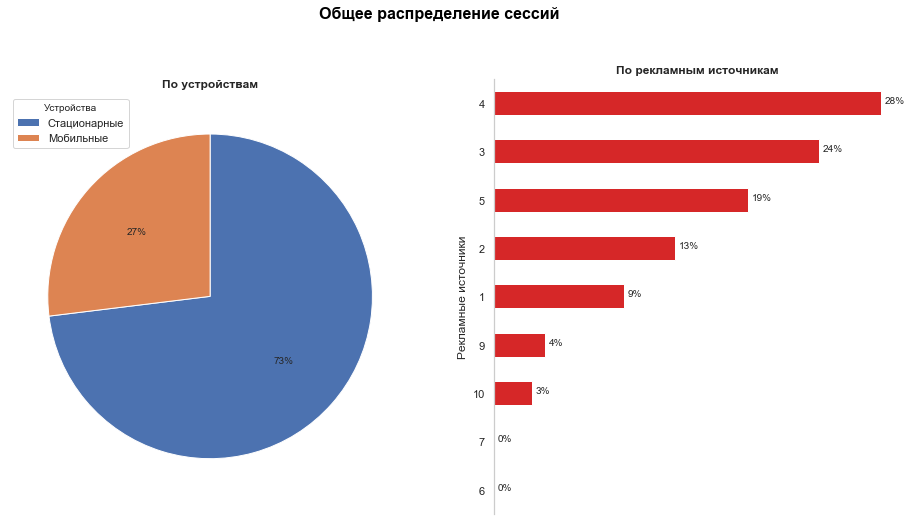

In [31]:
# график распределения открытия сессий
fig, (ax1, ax2) = plt.subplots(ncols=2)
fig.suptitle('Общее распределение сессий', **title_font)

g1 = ax1.pie(
    visits_by_device,
    autopct='%1.0f%%', 
    startangle=90,
    counterclock=False,

   # colors = ['tab:blue', 'tab:red']
)

g2 = visits_by_source.plot.barh(
    ax=ax2,
    color='tab:red',
)

ax1.set_title('По устройствам', weight='bold')
ax2.set_title('По рекламным источникам', weight='bold')

ax2.set(
#    title='', 
    ylabel='Рекламные источники',
    xlabel=''
)

ax1.legend(
    device_ticks,
    title='Устройства',
    loc="upper left",
    #bbox_to_anchor=(0.9, 0, 0, 1)
)


#ax2.spines['left'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.set_xticks([])
plt.grid(False)


for i, value in enumerate(visits_by_source):
    ax2.text(
        value+1000,
        i,
        '{:.0%}'.format(value/visits_by_source.sum()),
       # fontsize=8
    )


#ax2.legend(
#    visits_by_source.index, 
#    title='Рекламный источник',
#    loc="center left",
#    bbox_to_anchor=(0.9, 0, 0, 1)
#)

plt.show()

73% трафика идет со стационарных устройств.   
71% трафика идет от рекламных источников 4, 3 и 5.

##### Распределение сессий по устройствам и рекламным источникам

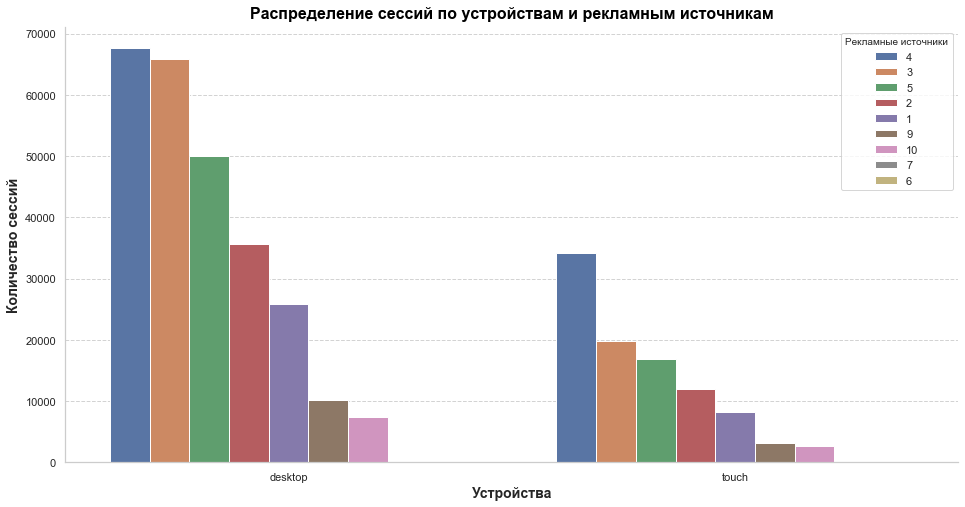

In [32]:
# датафрейм распределения открытия сессий
visits_by_device_and_source = visits.groupby(['device','source_id'])['source_id'].count().to_frame()#.unstack('source_id')

visits_by_device_and_source.columns = ['sessions']
visits_by_device_and_source = visits_by_device_and_source.reset_index()

source_order = visits_by_device_and_source.groupby('source_id')['sessions'].sum().sort_values(ascending=False).index
# график распределения открытия сессий
sns.barplot(
    x="device",
    y="sessions", 
    data=visits_by_device_and_source,
    hue='source_id',
    hue_order = source_order
)



# подписи данных
plt.title('Распределение сессий по устройствам и рекламным источникам', **title_font)
plt.xlabel('Устройства', **axis_font)
plt.ylabel('Количество сессий', **axis_font)

# границы графика и сетка
plt.grid(False)
plt.grid(
    color='lightgrey',
    which='major',
    axis='y',
    linestyle='--',
    
)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.legend(title='Рекламные источники', loc='upper right')

#plt.xticks(
#    range(len(device_ticks)),
#    device_ticks,
#
#    rotation=0
#)


plt.show()

В разрезе устройств, на стационарных устройствах почти нет разницы между трафиком от 4 и 3 источников.   
На мобильных устройствах разница трафика между 4 и 3 источниками более 30%.   

##### Распределение сессий во времени

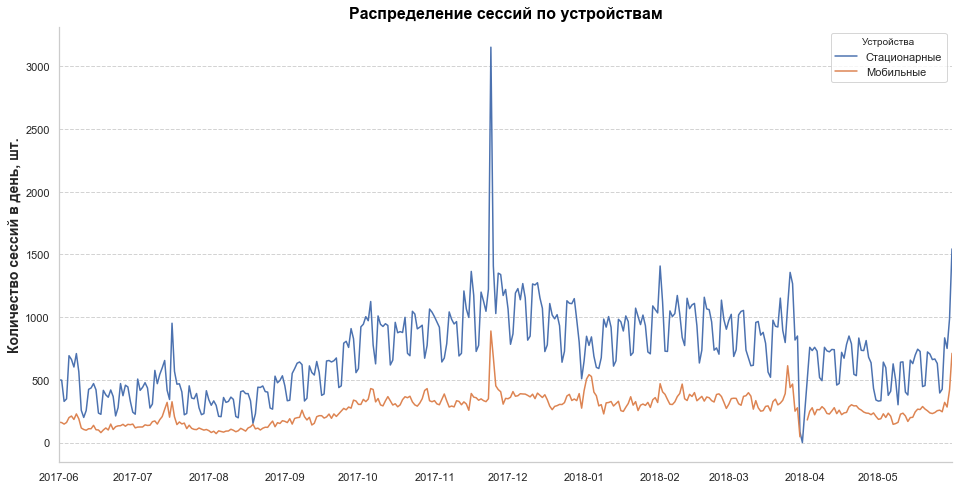

In [33]:
# датафрейм распределения сессий во времени по устройствам
visits_day_devices = visits.pivot_table(
    index='session_date',
    columns='device',
    values='uid',
    aggfunc='count',

)

# график распределения сессий во времени по устройствам
visits_day_devices.plot(
   # color = ['pink', 'tab:red']
)

# подписи данных
plt.title('Распределение сессий по устройствам', **title_font)
plt.ylabel('Количество сессий в день, шт.', **axis_font)
plt.xlabel('', **axis_font)

# границы графика и сетка
plt.grid(False)
plt.grid(
    color='lightgrey',
    which='major',
    axis='y',
    linestyle='--',
    
)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.legend(device_ticks, title='Устройства', loc='upper right')

plt.show()

Сезонность и недельная переодичность менее выражена для тренда сессий с мобильных устройств. Мобильные устройства всегда под рукой, в отличии от стационарных устройств, которые меньше используются на выходных.   
В теплое время года пользователи уезжают из городов и снижают активность посещения мероприятий. Обращения к сервису Яндекс.Афиша снижаются.

In [34]:
# датафрейм распределения сессий во времени по источникам рекламы
visits_day_sources = visits.pivot_table(
    index='session_date',
    columns='source_id',
    values='uid',
    aggfunc='count'
)

visits_day_sources = visits_day_sources.reindex(columns=visits_day_sources.sum().sort_values(ascending=False).index)

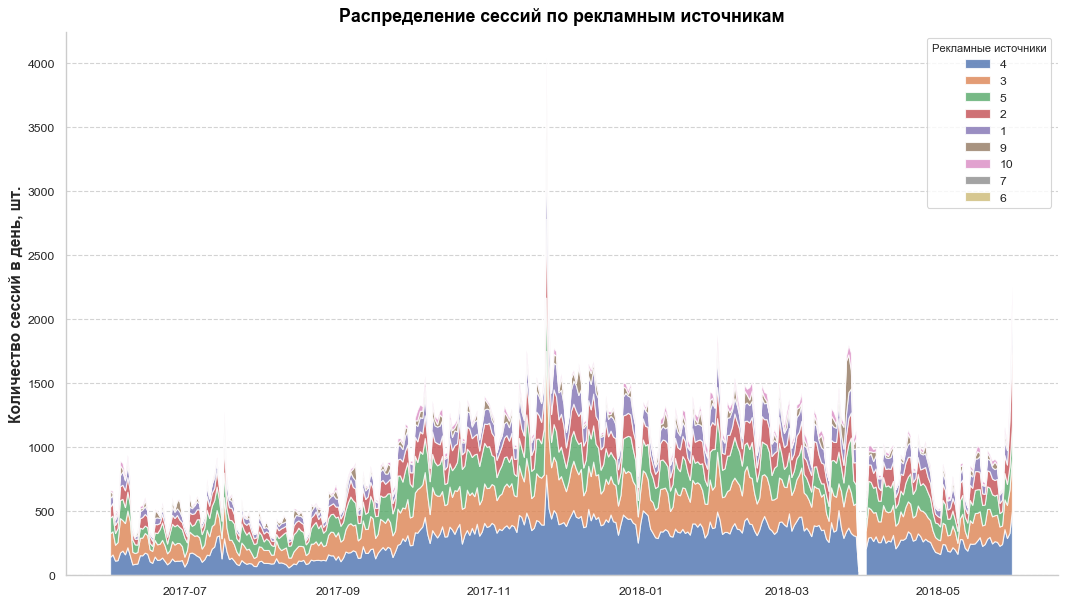

In [35]:
# график распределения сессий во времени по источникам рекламы
fig, ax = plt.subplots(1,1,figsize=(16, 9), dpi= 80)

# значения оси х
x  = visits_day_sources.index.tolist()
# значения оси y
y = np.vstack(visits_day_sources[x].values.tolist() for x in visits_day_sources.columns)

ax = plt.gca()

ax.stackplot(
    x, 
    y, 
    labels=visits_day_sources.columns,
   # colors=mycolors,
    alpha=0.8)

# подписи данных
plt.title('Распределение сессий по рекламным источникам', **title_font)
plt.ylabel('Количество сессий в день, шт.', **axis_font)
plt.xlabel('', **axis_font)

# границы графика и сетка
plt.grid(False)
plt.grid(
    color='lightgrey',
    which='major',
    axis='y',
    linestyle='--',
    
)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.legend(title='Рекламные источники', loc='upper right')

plt.show()

Независимо от сезона и дня недели, основные источники трафика: 4, 3 и 5.

##### Среднее количество сессий в день

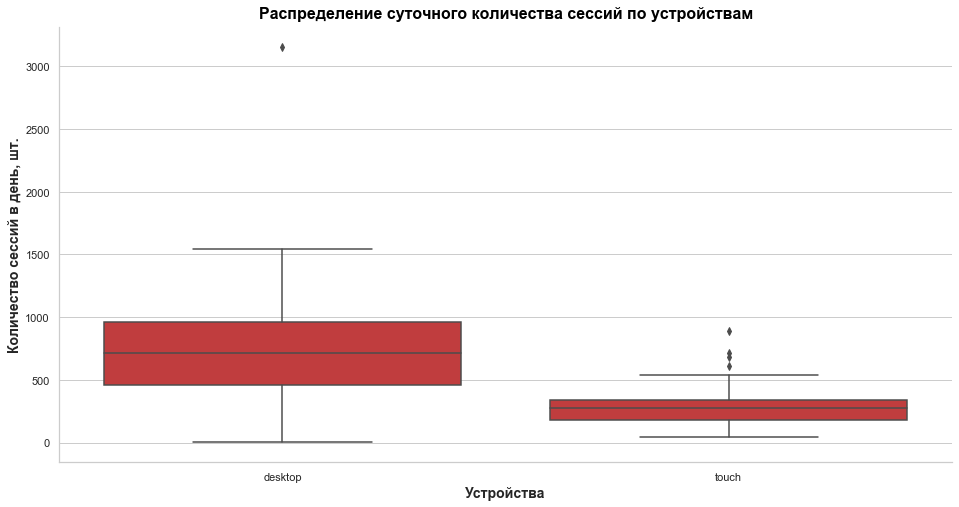

In [36]:
sns.boxplot(
    data=visits_day_devices,
    color='tab:red'
)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.title('Распределение суточного количества сессий по устройствам', **title_font)
plt.ylabel('Количество сессий в день, шт.', **axis_font)
plt.xlabel('Устройства', **axis_font)

plt.show()

In [37]:
print('Среднее количество сессий в день по устройствам:\n \
    стационарные: {}\n \
    мобильные: {}'.format(
    int(visits_day_devices.mean()[0]),
    int(visits_day_devices.mean()[1])
))

Среднее количество сессий в день по устройствам:
     стационарные: 721
     мобильные: 266


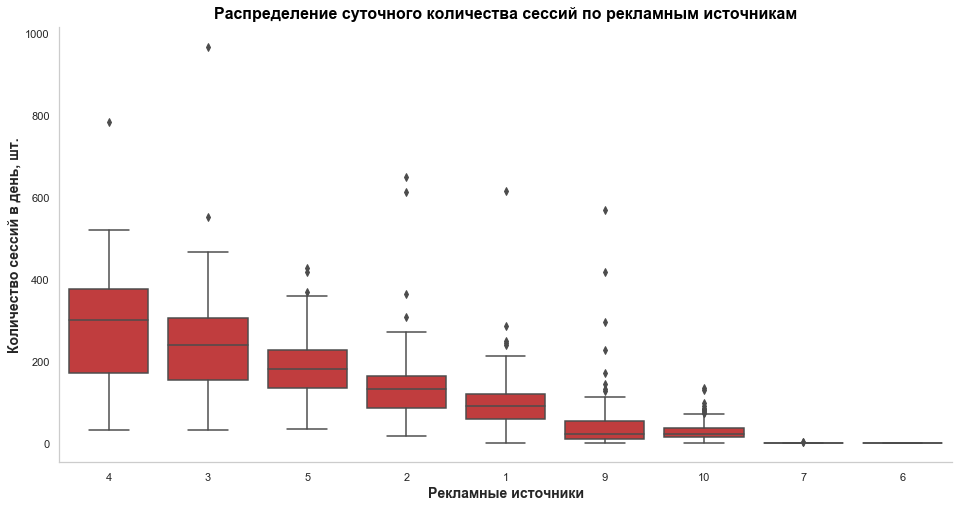

In [38]:
sns.boxplot(
    data=visits_day_sources,
    color='tab:red'
)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.title('Распределение суточного количества сессий по рекламным источникам', **title_font)
plt.ylabel('Количество сессий в день, шт.', **axis_font)
plt.xlabel('Рекламные источники', **axis_font)
#plt.xticks(range(2), ['device_ticks','w'], rotation=0)
plt.grid(False)

plt.show()

In [39]:
print('Среднее количество сессий в день по рекламным источникам:')
for i, source in enumerate(visits_day_sources.mean()):
    print('{} - {}'.format(
        visits_day_sources.columns[i], 
        int(source)))

Среднее количество сессий в день по рекламным источникам:
4 - 280
3 - 235
5 - 184
2 - 131
1 - 93
9 - 36
10 - 27
7 - 1
6 - 1


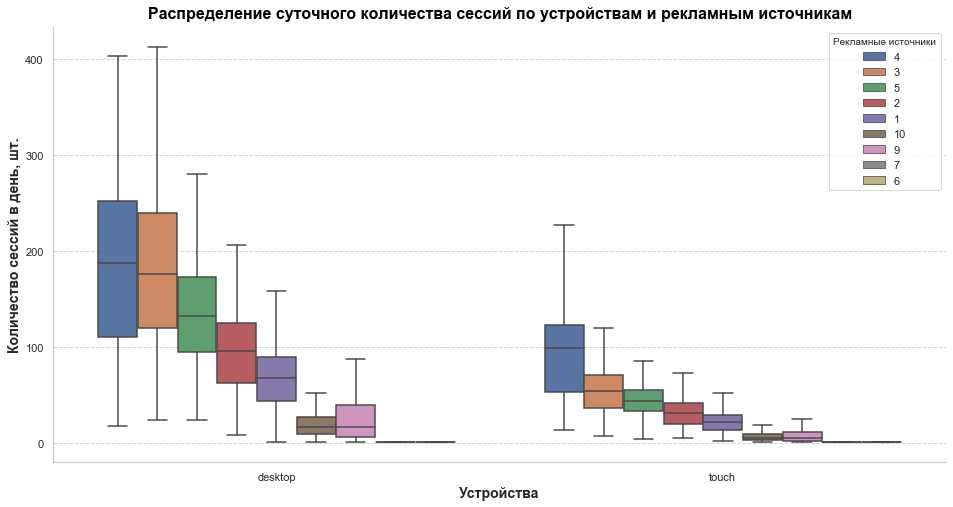

In [40]:
visits_pivot = visits.pivot_table(
    index=['session_date','source_id', 'device'],
  #  columns='source_id',
    values='uid',
    aggfunc='count'
).reset_index()

sns.boxplot(
    x="device",
    y="uid",
    hue="source_id",
    data=visits_pivot,
    showfliers=False,
#    palette='Reds_r'
    hue_order = visits_pivot.groupby('source_id')['uid'].median().sort_values(ascending=False).index
)

# подписи данных
plt.title('Распределение суточного количества сессий по устройствам и рекламным источникам', **title_font)
plt.xlabel('Устройства', **axis_font)
plt.ylabel('Количество сессий в день, шт.', **axis_font)

# границы графика и сетка
plt.grid(False)
plt.grid(
    color='lightgrey',
    which='major',
    axis='y',
    linestyle='--',
    
)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.legend(
    title='Рекламные источники', 
   # loc="upper left",
 #   bbox_to_anchor=(1, 0, 0, 1)

)

#plt.xticks(range(len(device_ticks)), device_ticks, rotation=0)
plt.show()

Активность пользователей со стационарных устройств больше и дольше, чем с мобильных. Это необходимо учитывать при планировании маркетинговой стратегии.

####  Уникальные пользователи

##### Средние показатели

In [41]:
dau_mean = int(visits.groupby('session_date').agg({'uid': 'nunique'}).mean())
wau_mean = int(visits.groupby(['session_year', 'session_week']).agg({'uid': 'nunique'}).mean())
mau_mean = int(visits.groupby(['session_year', 'session_month']).agg({'uid': 'nunique'}).mean())

print('Среднее количество уникальных пользователей за исследуемый период 12 месяцев:\n \
      в день: {}\n \
      в неделю: {}\n \
      в месяц: {}'.format(dau_mean, wau_mean, mau_mean))

Среднее количество уникальных пользователей за исследуемый период 12 месяцев:
       в день: 907
       в неделю: 5716
       в месяц: 23228


##### Тренды

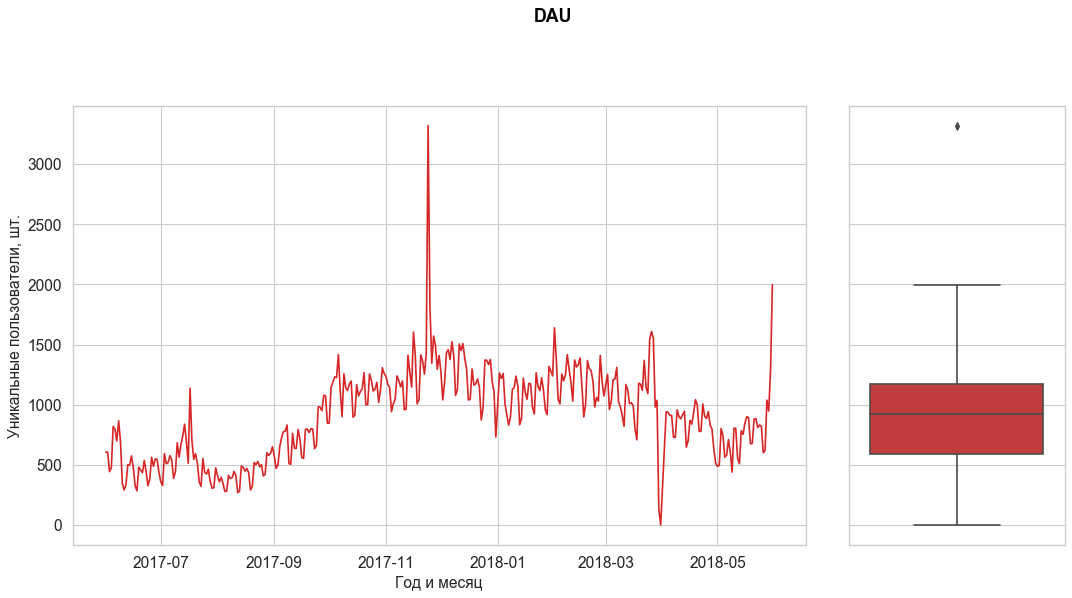

In [42]:
# датафрейм
visits_dau = visits.groupby('session_date').agg({'uid': 'nunique'})
day_ticks = list(visits_dau.index)

# подписи
date_ticks = list(pd.date_range(
    start=visits_dau.index.min(), 
    end=visits_dau.index.max(),
    freq='MS').strftime('%Y-%m')  
)

# график
fig = plt.figure(figsize=(16, 10), dpi= 80)
grid = plt.GridSpec(4, 4, hspace=0.5, wspace=0.2)

# определение осей
ax_main = fig.add_subplot(
    grid[:-1, :-1],
 #   xticklabels=date_ticks,
#    xticks=range(len(date_ticks))
)
ax_right = fig.add_subplot(
    grid[:-1, -1],
    xticklabels=[],
    yticklabels=[]
)

# непосредственно графики
ax_main.plot(
    visits_dau,
    color='tab:red',
)

sns.boxplot(
    visits_dau,
    ax=ax_right,
    orient="v",
    color='tab:red',

)

ax_right.set(ylabel='')

#dau_ticks = list(visits_dau.index.get_level_values('session_week'))
#ax_main.set_xticks(range(len(date_ticks)))
#ax_main.set_xticklabels(date_ticks)


ax_main.set(
#    title='', 
    xlabel='Год и месяц',
    ylabel='Уникальные пользователи, шт.'
)
fig.suptitle('DAU', **title_font)

for item in ([ax_main.xaxis.label, ax_main.yaxis.label] + ax_main.get_xticklabels() + ax_main.get_yticklabels()):
    item.set_fontsize(14)


plt.show()

In [43]:
# максимумы посещений
visits_dau.sort_values('uid', ascending=False).head()

,uid
session_date,
2017-11-24,3319
2018-05-31,1997
2017-11-25,1817
2018-02-01,1640
2018-03-26,1609


In [44]:
# минимумы посещений
visits_dau.sort_values('uid', ascending=True).head()

,uid
session_date,
2018-03-31,1
2018-03-30,131
2017-08-12,271
2017-08-05,280
2017-08-13,281


Тренд ежедневного посещения уникальных пользователей пилообразный.   
Наблюдаются провалы посещений в выходные дни до 30% относительно будних дней.   
Среднее значение за период - 907 уникальных посещений в день.   
Начальные значения летом 2017 года около 500 посещений и на пиках в ноябре 2017 года до 1500.   
Есть отдельные выбросы 24/11 и 31/05 и провал 31/03. __Необходимо провести дополнительный анализ причин пиков и провалов.__

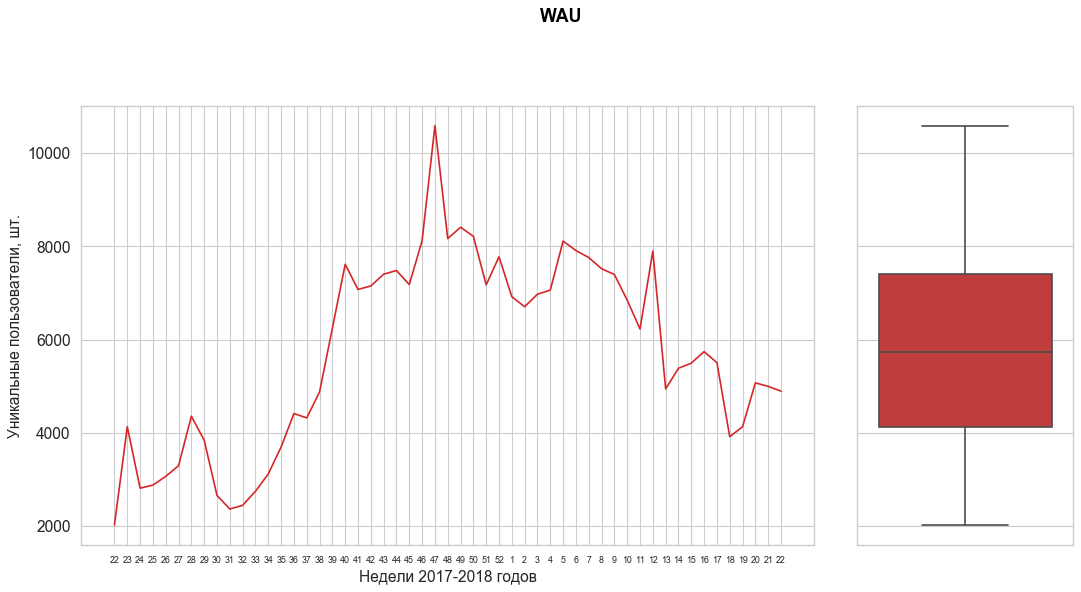

In [45]:
# датафрейм
visits_wau = visits.groupby(['session_year', 'session_week']).agg({'uid': 'nunique'})

# график
fig = plt.figure(figsize=(16, 10), dpi= 80)
grid = plt.GridSpec(4, 4, hspace=0.5, wspace=0.2)

# определение осей
ax_main = fig.add_subplot(
    grid[:-1, :-1], 
)
ax_right = fig.add_subplot(
    grid[:-1, -1],
    xticklabels=[], 
    yticklabels=[]
)

# непосредственно графики

ax_main.plot(
    visits_wau.values,
    color='tab:red',
)

wau_ticks = list(visits_wau.index.get_level_values('session_week'))
ax_main.set_xticks(range(len(wau_ticks)))
ax_main.set_xticklabels(wau_ticks)


sns.boxplot(
    visits_wau,
    ax=ax_right,
    orient="v",
    color='tab:red',

)

ax_right.set(ylabel='')

ax_main.set(
#    title='', 
    xlabel='Недели 2017-2018 годов',
    ylabel='Уникальные пользователи, шт.'
)
fig.suptitle('WAU', **title_font)

for item in ([ax_main.xaxis.label, ax_main.yaxis.label] + ax_main.get_xticklabels()):
    item.set_fontsize(8)

for item in ([ax_main.xaxis.label, ax_main.yaxis.label] + ax_main.get_yticklabels()):
    item.set_fontsize(14)
    
plt.show()

Тренд еженедельного прироста уникальных пользователей неравномерный.   
Среднее значение за период - 5716.
Начальные значения в июне 2017 года около 2000 и на пике в ноябре 2017 года выше 10000.   
Спустя год в июне 2018 года еженедельный прирост около 5000.

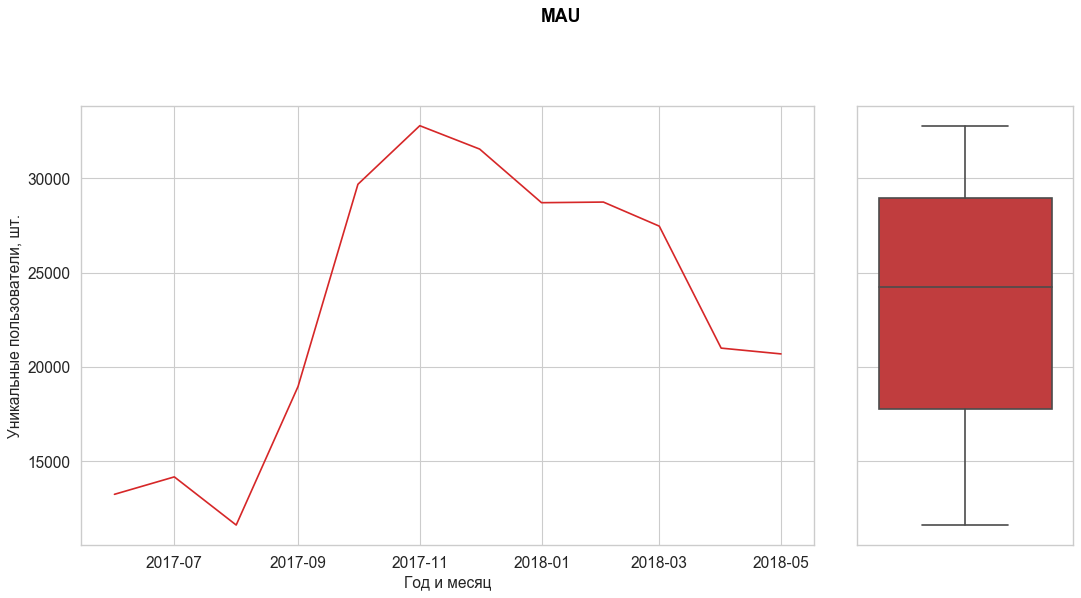

In [46]:
# датафрейм
visits_mau = visits.groupby('session_month').agg({'uid': 'nunique'})

# график
fig = plt.figure(figsize=(16, 10), dpi= 80)
grid = plt.GridSpec(4, 4, hspace=0.5, wspace=0.2)

# определение осей
ax_main = fig.add_subplot(grid[:-1, :-1])
ax_right = fig.add_subplot(grid[:-1, -1], xticklabels=[], yticklabels=[])

# непосредственно графики
ax_main.plot(
    visits_mau,
    color='tab:red',
)

sns.boxplot(
    visits_mau,
    ax=ax_right,
    orient="v",
    color='tab:red',

)

ax_right.set(ylabel='')

ax_main.set(
#    title='', 
    xlabel='Год и месяц',
    ylabel='Уникальные пользователи, шт.'
)
fig.suptitle('MAU', **title_font)

for item in ([ax_main.xaxis.label, ax_main.yaxis.label] + ax_main.get_xticklabels() + ax_main.get_yticklabels()):
    item.set_fontsize(14)

plt.show()

Тренд ежемесячного прироста уникальных пользователей довольно плавный.   
Среднее значение за период - 23228.
Начальные значения в июне 2017 года около 13500 и на пике в ноябре 2017 года выше 33000.   
Спустя год в июне 2018 года еженедельный прирост более 20000.

#### Возвращение пользователей

##### Средние показатели

In [47]:
sticky_wau_mean = dau_mean / wau_mean * 100
sticky_mau_mean = dau_mean / mau_mean * 100

print('Средний фактор возвращения пользователей \n \
      в неделю: {:.1f}% (50-60% — экспертный оптимум для ресурсов, кроме игр и соц. сетей)\n \
      в месяц: {:.1f}% (20-25% — экспертный оптимум для ресурсов, кроме игр и соц. сетей)'.format(sticky_wau_mean, sticky_mau_mean))

Средний фактор возвращения пользователей 
       в неделю: 15.9% (50-60% — экспертный оптимум для ресурсов, кроме игр и соц. сетей)
       в месяц: 3.9% (20-25% — экспертный оптимум для ресурсов, кроме игр и соц. сетей)


По оценкам отраслевых экспертов (<a href="https://rb.ru/longread/product-metrics/">ссылка 1</a>, 
<a href="https://www.quora.com/Are-there-any-stats-out-there-for-WAU-MAU-When-is-it-more-appropriate-than-DAU-MAU">ссылка 2</a>), если показатель sticky mau ниже 5%, стоит предпринять меры по увеличению возврата пользователей, например, дополнить сервис новыми функциями.

##### Тренды

In [48]:
# датафрейм

sticky_wau_trend = (
    # датафрейм средненедельных DAU
    visits.groupby(
        ['session_month', 'session_week', 'session_date']
    ).agg({'uid': 'nunique'}).reset_index().groupby(
        ['session_month', 'session_week']
    ).agg({'uid': 'mean'})
    /
    # датафрейм  WAU 
    visits.groupby(['session_month', 'session_week']).agg({'uid': 'nunique'})
) * 100

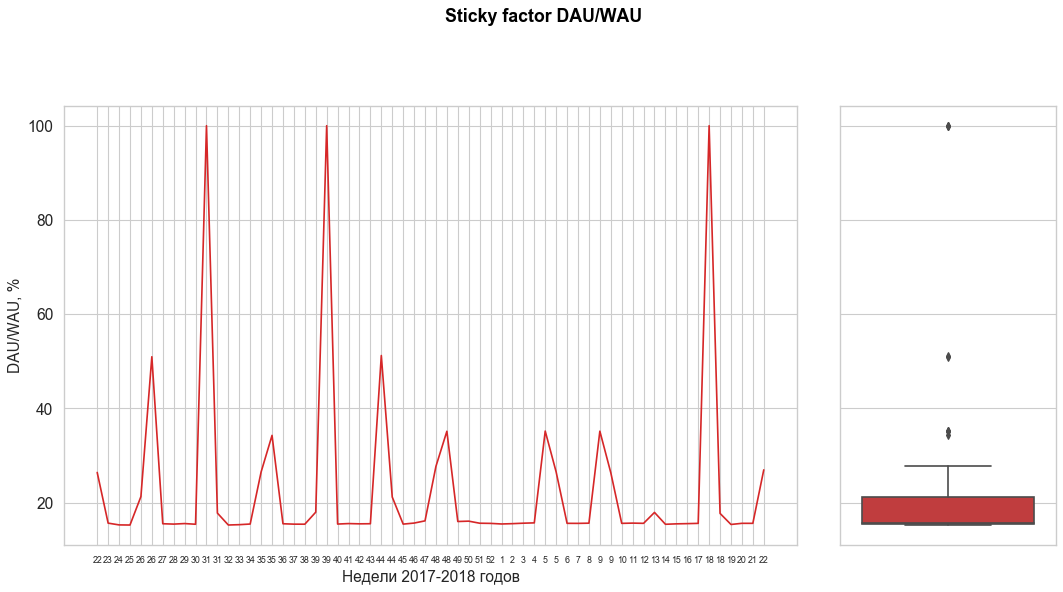

In [49]:
# график
fig = plt.figure(figsize=(16, 10), dpi= 80)
grid = plt.GridSpec(4, 4, hspace=0.5, wspace=0.2)

# определение осей
ax_main = fig.add_subplot(
    grid[:-1, :-1], 
)
ax_right = fig.add_subplot(
    grid[:-1, -1],
    xticklabels=[], 
    yticklabels=[]
)

# непосредственно графики

ax_main.plot(
    sticky_wau_trend.values,
    color='tab:red',
)

wau_ticks = list(sticky_wau_trend.index.get_level_values('session_week'))
ax_main.set_xticks(range(len(wau_ticks)))
ax_main.set_xticklabels(wau_ticks)


sns.boxplot(
    sticky_wau_trend,
    ax=ax_right,
    orient="v",
    color='tab:red',

)

ax_right.set(ylabel='')

ax_main.set(
#    title='', 
    xlabel='Недели 2017-2018 годов',
    ylabel='DAU/WAU, %'
)
fig.suptitle('Sticky factor DAU/WAU', **title_font)

for item in ([ax_main.xaxis.label, ax_main.yaxis.label] + ax_main.get_xticklabels()):
    item.set_fontsize(8)

for item in ([ax_main.xaxis.label, ax_main.yaxis.label] + ax_main.get_yticklabels()):
    item.set_fontsize(14)
    
plt.show()

In [50]:
# пики sticky wau
sticky_wau_trend.sort_values('uid',ascending=False).head()

uid
session_month session_week      
2017-07-01    31           100.0
2018-04-01    18           100.0
2017-10-01    39           100.0
              44            51.2
2017-07-01    26            51.0

In [51]:
# возможный минимум sticky wau
sticky_wau_trend.sort_values('uid',ascending=True).head()

,,uid
session_month,session_week,
2017-06-01,25,15.2
2017-08-01,32,15.2
2017-06-01,24,15.3
2017-08-01,33,15.3
2018-05-01,19,15.4


Диапазон sticky wau примерно половину периода расположен у минимально возможного значения 15,2. Это значит, что пользователи вне рекламных кампаний не приходят повторно.
Наблюдаются пики прихода уникальных пользователй в ноябре 2017 года и в апреде 2018 года.
Вероятно, это связано с сезонным фактором и рекламными кампаниями.

In [52]:
sticky_mau_trend = (
    # датафрейм среднего DAU за месяц
    visits.groupby(['session_month','session_date']).agg({'uid': 'nunique'}).mean(level=0)
    /
    visits_mau) * 100

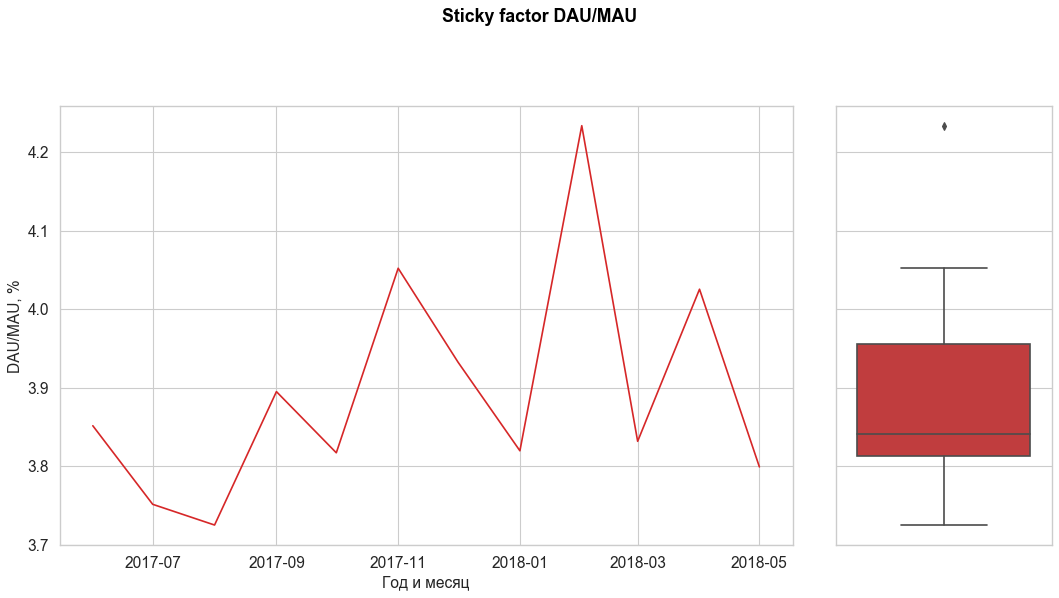

In [53]:
# создание Fig and gridspec
fig = plt.figure(figsize=(16, 10), dpi= 80)
grid = plt.GridSpec(4, 4, hspace=0.5, wspace=0.2)

# определение осей
ax_main = fig.add_subplot(grid[:-1, :-1])
ax_right = fig.add_subplot(grid[:-1, -1], xticklabels=[], yticklabels=[])

# непосредственно графики
ax_main.plot(
    sticky_mau_trend,
    color='tab:red',
)

sns.boxplot(
    sticky_mau_trend,
    ax=ax_right,
    orient="v",
    color='tab:red',

)

ax_right.set(ylabel='')

ax_main.set(
#    title='', 
    xlabel='Год и месяц',
    ylabel='DAU/MAU, %'
)
fig.suptitle('Sticky factor DAU/MAU', **title_font)

for item in ([ax_main.xaxis.label, ax_main.yaxis.label] + ax_main.get_xticklabels() + ax_main.get_yticklabels()):
    item.set_fontsize(14)

plt.show()

Диапазон sticky factor mau за исследуемый период между 3,8-4,0 с сезонным выбросом 4,2 в феврале 2018 года. Пиковые значения не превыщают минимальный уровень успешно функционирующего сервиса, по <a href="https://rb.ru/longread/product-metrics/">оценкам</a>  отраслевых экспертов.

#### Длительность сессий

Построение технического графика для определения функции для продолжительности сессии: среднего, медианы или моды.

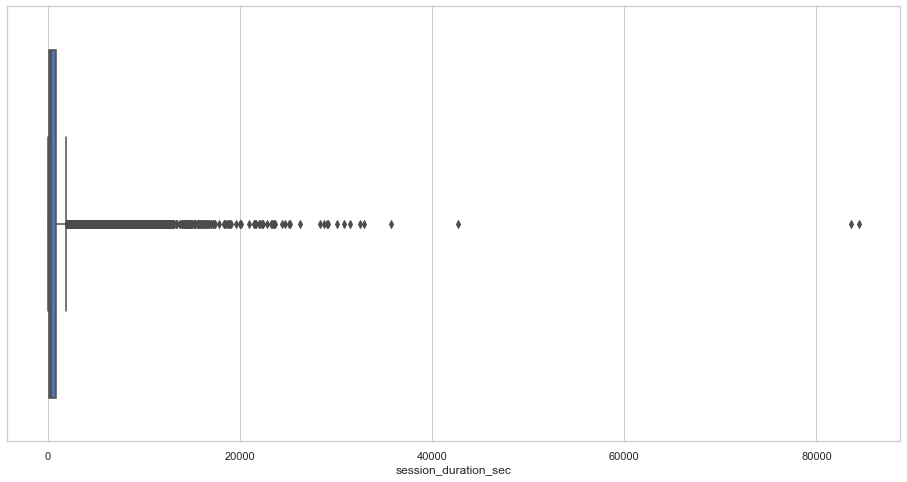

In [54]:
sns.boxplot(
    visits['session_duration_sec']
)
plt.show()

Распределение длительности сессий имеет много выбросов. Вероятно, они пользователь открыл сессию и ушел от компьютера. 
Среднее для расчета продолжительности нельзя использовать.   

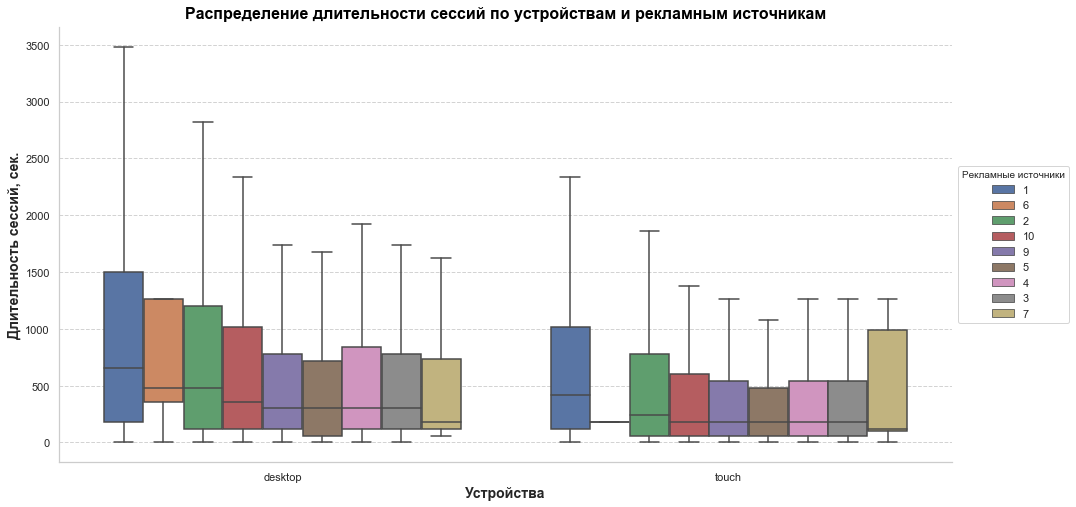

In [55]:
sns.boxplot(
    x="device",
    order=['desktop','touch'],
    y="session_duration_sec",
    hue="source_id",
    data=visits,
    showfliers=False,
#    palette='Reds_r'
    hue_order = visits.groupby('source_id')['session_duration_sec'].median().sort_values(ascending=False).index
)

# подписи данных
plt.title('Распределение длительности сессий по устройствам и рекламным источникам', **title_font)
plt.xlabel('Устройства', **axis_font)
plt.ylabel('Длительность сессий, сек.', **axis_font)

# границы графика и сетка
plt.grid(False)
plt.grid(
    color='lightgrey',
    which='major',
    axis='y',
    linestyle='--',
    
)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.legend(
    title='Рекламные источники', 
    loc="center left",
    bbox_to_anchor=(1, 0, 0, 1)

)

#plt.xticks(range(len(device_ticks)), ['Мобильные', 'Стационарные'], rotation=0)
plt.show()

In [56]:
# длительность сессии
asl_desktope_mode = int(visits.query('device == "desktop"')['session_duration_sec'].mode())
asl_touch_mode = int(visits.query('device == "touch"')['session_duration_sec'].mode())
asl_desktope_median = int(visits.query('device == "desktop"')['session_duration_sec'].median())
asl_touch_median = int(visits.query('device == "touch"')['session_duration_sec'].median())

print('Медиана длительности сессий, сек.:\n \
      на мобильных устройствах: {}\n \
      на стационарных компьютерах: {}.'.format(asl_touch_median, asl_desktope_median))
print()
print('Мода длительности сессий, сек.:\n \
      на мобильных устройствах: {}\n \
      на стационарных компьютерах: {}.'.format(asl_touch_mode, asl_desktope_mode))

Медиана длительности сессий, сек.:
       на мобильных устройствах: 180
       на стационарных компьютерах: 360.

Мода длительности сессий, сек.:
       на мобильных устройствах: 60
       на стационарных компьютерах: 60.


##### Проверка коротких и нулевых сессий

In [57]:
# срез по нулевым сессиям
zero_sessions = visits.query('session_duration_sec == 0')

In [58]:
print('Доля сессий нулевой длительности: {:.0%}.'.format(len(zero_sessions) / len(visits)))

Доля сессий нулевой длительности: 10%.


In [59]:
# датафреймы для графиков
zero_sessions_by_device = zero_sessions.groupby('device')['device'].count().sort_values(ascending=False)
zero_sessions_by_source = zero_sessions.groupby('source_id')['source_id'].count().sort_values(ascending=True)

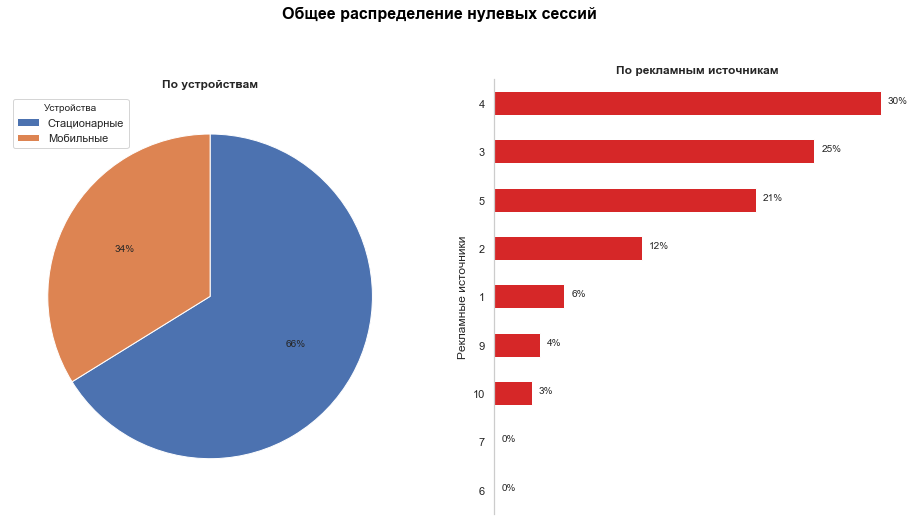

In [60]:
# график распределения открытия сессий
fig, (ax1, ax2) = plt.subplots(ncols=2)
fig.suptitle('Общее распределение нулевых сессий', **title_font)

g1 = ax1.pie(
    zero_sessions_by_device,
    autopct='%1.0f%%', 
    startangle=90,
    counterclock=False,

   # colors = ['tab:blue', 'tab:red']
)

g2 = zero_sessions_by_source.plot.barh(
    ax=ax2,
    color='tab:red',
)

ax1.set_title('По устройствам', weight='bold')
ax2.set_title('По рекламным источникам', weight='bold')

ax2.set(
#    title='', 
    ylabel='Рекламные источники',
    xlabel=''
)

ax1.legend(
    device_ticks,
    title='Устройства',
    loc="upper left",
    #bbox_to_anchor=(0.9, 0, 0, 1)
)


#ax2.spines['left'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.set_xticks([])
plt.grid(False)


for i, value in enumerate(zero_sessions_by_source):
    ax2.text(
        value+200,
        i,
        '{:.0%}'.format(value/zero_sessions_by_source.sum()),
       # fontsize=8
    )


#ax2.legend(
#    visits_by_source.index, 
#    title='Рекламный источник',
#    loc="center left",
#    bbox_to_anchor=(0.9, 0, 0, 1)
#)

plt.show()

Примерно треть нулевых сессий приходится на мобильные устройства.   
От 20 до 30% нулевых сессий от рекламных источников 4, 3, 5.

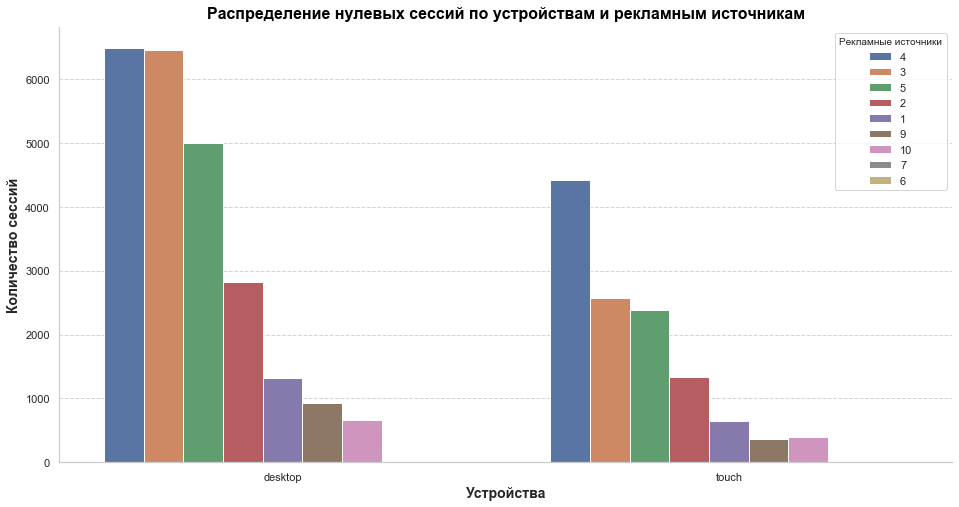

In [61]:
# датафрейм распределения открытия сессий
zero_sessions_by_device_and_source = zero_sessions.groupby(['device','source_id'])['source_id'].count().to_frame()#.unstack('source_id')

zero_sessions_by_device_and_source.columns = ['sessions']
zero_sessions_by_device_and_source = zero_sessions_by_device_and_source.reset_index()

# график распределения открытия сессий
sns.barplot(
    x="device",
    y="sessions", 
    data=zero_sessions_by_device_and_source,
    hue='source_id',
    hue_order = zero_sessions_by_device_and_source.groupby('source_id')['sessions'].sum().sort_values(ascending=False).index
)



# подписи данных
plt.title('Распределение нулевых сессий по устройствам и рекламным источникам', **title_font)
plt.xlabel('Устройства', **axis_font)
plt.ylabel('Количество сессий', **axis_font)

# границы графика и сетка
plt.grid(False)
plt.grid(
    color='lightgrey',
    which='major',
    axis='y',
    linestyle='--',
    
)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.legend(title='Рекламные источники', loc='upper right')

#plt.xticks(
#    range(len(device_ticks)),
#    device_ticks,
#
#    rotation=0
#)

    

plt.show()

- Нулевые сессии:
    - Доля нулевых сессий: 10%. 
    - 34%  нулевых сессий приходится на мобильные устройства.
    - Примерно по трети нулевых сессий приходят от рекламных источников 4, 3 и 5.   
    


#### Промежуточный вывод по активности пользователей по продукту

__Результаты:__
- Среднее количество уникальных пользователей за исследуемый период:
    - в день: 907. Тренд пилообразный, ярко выражены провалы выходных до 30%.
    - в неделю: 5716. Тренд неравномерный, паттерн не наблюдается.
    - в месяц: 23228. Тренд плавного роста под Новый Год со спадом летом.
- Источники трафика:
    - 73% со стационарных устройств
    - 71% от рекламных источников 4, 3 и 5
- Среднее количество сессий
    - на пользователя: 1,08
    - по устройствам:
        - стационарные: 721
        - мобильные: 266
    - по рекламным источникам:
        - 4 - 280
        - 3 - 235
        - 5 - 184
        - 2 - 131
        - 1 - 93
        - 9 - 36
        - 10 - 27
        - 7 - 1
        - 6 - 1

- Медианная длительность сессии, сек.:
    - на мобильных устройствах: 180
    - на стационарных компьютерах: 360
- 10% всех сессий нулевой длительности. Треть из них приходится на мобильные устройства. Более 80% нулевых сессий приходят от рекламных источников 4, 3, 5.
- Средний фактор возвращения пользователей __sticky factor, %__:
    - в неделю sticky wau: __15,9__. Sticky wau примерно половину исследуемого периода расположен у минимально возможного значения 15,2. Это значит, что пользователи почти не приходят повторно.
    - в месяц sticky mau: __3,9__. Sticky mau ниже минимального уровеня успешно функционирующего сервиса, по оценкам отраслевых экспертов.

__Рекомендации:__
       
- Показатель sticky mau ниже 5%. По оценкам отраслевых экспертов, в таких случаях стоит предпринять меры по увеличению возврата пользователей, например, дополнить сервис новыми функциями.
- Необходима проверка причин нулевых сессий по компетенции.
- Сезонность и недельная переодичность сессий менее выражена для тренда с мобильных устройств. Мобильные устройства всегда под рукой, в отличии от стационарных устройств, которые меньше используются на выходных. В теплое время года пользователи уезжают из городов и снижают активность посещения мероприятий. Обращения к сервису Яндекс.Афиша снижаются.
- Провести дополнительный анализ причин пиков и провалов посещений:
    - выбросы 24/11 и 31/05
    - провал 31/03

### Общие финансовые показатели
<a id = "general_financial"></a>

In [62]:
# суммарная выручка за весь период
print('Общая выручка {:.0f} руб.'.format(
    orders['revenue'].sum().round()))

# суммарные затраты за весь период
print('Общие затраты на маркетинг {:.0f} руб.'.format(
    costs['costs'].sum().round()))

print('Общий убыток за период: {:.0f} руб.'.format(orders['revenue'].sum() - costs['costs'].sum()))

Общая выручка 252054 руб.
Общие затраты на маркетинг 329132 руб.
Общий убыток за период: -77078 руб.


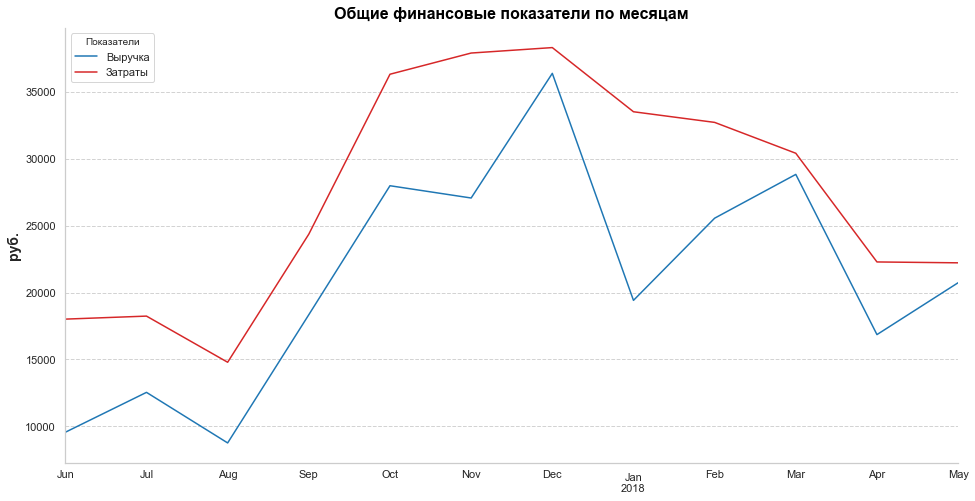

In [63]:
# свод общих финансовых показателей
revenue_by_month = orders.groupby('order_month')['revenue'].sum().to_frame()
costs_by_month = costs.groupby('cost_month')['costs'].sum().to_frame()
revenue_costs_by_month = revenue_by_month.join(costs_by_month)

# общий график финансовых показателей
revenue_costs_by_month.plot(
    color=['tab:blue', 'tab:red'],
)

# подписи данных
plt.title('Общие финансовые показатели по месяцам', **title_font)
plt.xlabel('', **axis_font)
#plt.gca().set_xticklabels(
#    revenue_costs_by_month.index.strftime('%Y-%m').to_list(),
#)
plt.ylabel('руб.', **axis_font)


# границы графика и сетка
plt.grid(False)
plt.grid(
    color='lightgrey',
    which='major',
    axis='y',
    linestyle='--'
)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.legend(
    title='Показатели',
    labels=['Выручка', 'Затраты'],
    loc='upper left')

plt.show()

За период  12 месяцев выручка стабильно меньше затрат.      
Необходимо проанализировать перспективу выхода из убытка — LTV и потенциал оптимизации затрат на маркетинг.

### Формирование когорт
<a id = "cohorts"></a>

In [64]:
# определение даты первой покупки пользователя
first_order = orders.groupby('uid').agg({'buy_ts': 'min'}).reset_index()
first_order.rename(columns={'buy_ts':'first_order_datetime'}, inplace=True)
first_order['first_order_date'] = first_order['first_order_datetime'].dt.date
first_order['first_order_month'] = first_order['first_order_datetime'].astype('datetime64[M]')
first_order

,uid,first_order_datetime,first_order_date,first_order_month
0,313578113262317,2018-01-03 21:51:00,2018-01-03,2018-01-01
1,1575281904278712,2017-06-03 10:13:00,2017-06-03,2017-06-01
2,2429014661409475,2017-10-11 18:33:00,2017-10-11,2017-10-01
3,2464366381792757,2018-01-28 15:54:00,2018-01-28,2018-01-01
4,2551852515556206,2017-11-24 10:14:00,2017-11-24,2017-11-01
...,...,...,...,...
36517,18445147675727495770,2017-11-24 09:03:00,2017-11-24,2017-11-01
36518,18445407535914413204,2017-09-22 23:55:00,2017-09-22,2017-09-01
36519,18445601152732270159,2018-03-26 22:54:00,2018-03-26,2018-03-01
36520,18446156210226471712,2018-02-18 19:34:00,2018-02-18,2018-02-01


In [65]:
# определение даты первого посещения
first_visit = visits.groupby('uid').agg({'start_ts': 'min'}).reset_index()
first_visit['first_visit_date'] = first_visit['start_ts'].dt.date
first_visit['first_visit_month'] = first_visit['start_ts'].astype('datetime64[M]')
first_visit.rename(columns={'start_ts':'first_visit_datetime'}, inplace=True)
#first_visit['start_ts']
first_visit

,uid,first_visit_datetime,first_visit_date,first_visit_month
0,11863502262781,2018-03-01 17:27:00,2018-03-01,2018-03-01
1,49537067089222,2018-02-06 15:55:00,2018-02-06,2018-02-01
2,297729379853735,2017-06-07 18:47:00,2017-06-07,2017-06-01
3,313578113262317,2017-09-18 22:49:00,2017-09-18,2017-09-01
4,325320750514679,2017-09-30 14:29:00,2017-09-30,2017-09-01
...,...,...,...,...
228164,18446403737806311543,2017-11-30 03:36:00,2017-11-30,2017-11-01
228165,18446424184725333426,2017-12-06 20:32:00,2017-12-06,2017-12-01
228166,18446556406699109058,2018-01-01 16:29:00,2018-01-01,2018-01-01
228167,18446621818809592527,2017-12-27 13:27:00,2017-12-27,2017-12-01


In [66]:
# свод в один датафрейм
first_visits_orders = pd.merge(first_visit, first_order, on='uid', how='left')

# определение периода до первой покупки пользователя
first_visits_orders['first_order_period'] = (first_visits_orders['first_order_datetime'] 
                                            - first_visits_orders['first_visit_datetime'])

# округление до дней
first_visits_orders['first_order_period_days'] = first_visits_orders['first_order_period'].dt.days
first_visits_orders['first_order_period_hours'] = first_visits_orders['first_order_period'] / np.timedelta64(1, 'h')

first_visits_orders

,uid,first_visit_datetime,first_visit_date,first_visit_month,first_order_datetime,first_order_date,first_order_month,first_order_period,first_order_period_days,first_order_period_hours
0,11863502262781,2018-03-01 17:27:00,2018-03-01,2018-03-01,NaT,NaN,NaT,NaT,nan,nan
1,49537067089222,2018-02-06 15:55:00,2018-02-06,2018-02-01,NaT,NaN,NaT,NaT,nan,nan
2,297729379853735,2017-06-07 18:47:00,2017-06-07,2017-06-01,NaT,NaN,NaT,NaT,nan,nan
3,313578113262317,2017-09-18 22:49:00,2017-09-18,2017-09-01,2018-01-03 21:51:00,2018-01-03,2018-01-01,106 days 23:02:00,106.0,"2,567.0"
4,325320750514679,2017-09-30 14:29:00,2017-09-30,2017-09-01,NaT,NaN,NaT,NaT,nan,nan
...,...,...,...,...,...,...,...,...,...,...
228164,18446403737806311543,2017-11-30 03:36:00,2017-11-30,2017-11-01,NaT,NaN,NaT,NaT,nan,nan
228165,18446424184725333426,2017-12-06 20:32:00,2017-12-06,2017-12-01,NaT,NaN,NaT,NaT,nan,nan
228166,18446556406699109058,2018-01-01 16:29:00,2018-01-01,2018-01-01,NaT,NaN,NaT,NaT,nan,nan
228167,18446621818809592527,2017-12-27 13:27:00,2017-12-27,2017-12-01,NaT,NaN,NaT,NaT,nan,nan


In [67]:
# подготовка датафрейма с uid только покупок
visits_short = visits.query('uid in @first_order.uid and session_date in @first_order.first_order_date')
visits_short

,device,end_ts,source_id,start_ts,uid,session_date,session_year,session_month,session_week,session_duration_sec
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-20,2018,2018-05-01,20,1440
5,desktop,2017-09-03 21:36:00,5,2017-09-03 21:35:00,16007536194108375387,2017-09-03,2017,2017-09-01,35,60
12,desktop,2018-02-06 15:50:00,4,2018-02-06 15:45:00,8056418121947262981,2018-02-06,2018,2018-02-01,6,300
15,touch,2018-02-12 20:30:00,2,2018-02-12 19:24:00,18188358787673499603,2018-02-12,2018,2018-02-01,7,3960
25,desktop,2017-12-05 10:28:00,4,2017-12-05 10:21:00,2307401184189569202,2017-12-05,2017,2017-12-01,49,420
...,...,...,...,...,...,...,...,...,...,...
359395,desktop,2017-07-29 19:07:19,2,2017-07-29 19:07:00,18363291481961487539,2017-07-29,2017,2017-07-01,30,19
359396,touch,2018-01-25 17:38:19,1,2018-01-25 17:38:00,18370831553019119586,2018-01-25,2018,2018-01-01,4,19
359397,desktop,2018-03-03 10:12:19,4,2018-03-03 10:12:00,18387297585500748294,2018-03-03,2018,2018-03-01,9,19
359398,desktop,2017-11-02 10:12:19,5,2017-11-02 10:12:00,18388616944624776485,2017-11-02,2017,2017-11-01,44,19


__Сопоставление рекламного источника и покупки выполняется около 10 минут!__

___

In [68]:
def source_id_date_check(buy_ts, uid):
    # проверка однозначной покупки в пределах сессии
    try:
        source_id = visits_short.query('uid == @uid and start_ts <= @buy_ts and end_ts >= @buy_ts')['source_id'].values[0]
    except:
        source_id = 0
    return source_id

In [69]:
_orders = orders.copy()
_orders['source_id'] = _orders.apply(lambda x: source_id_date_check(x.buy_ts, x.uid), axis=1)

In [70]:
# привязка первого месяца покупки 
orders_new = pd.merge(_orders, first_order, on='uid')

In [71]:
# формирование датафрейма когорт
orders_by_cohorts = orders_new.groupby(['first_order_month','order_month']).agg({
    'buy_ts':'count',
    'uid':'nunique',
    'revenue':'sum'})
orders_by_cohorts.rename(columns={'buy_ts':'orders', 'uid': 'buyers'}, inplace=True)
orders_by_cohorts = orders_by_cohorts.reset_index()

# добавление изначального количества покупателей
cohort_sizes = first_order.groupby('first_order_month').agg({'uid': 'nunique'}).reset_index()
cohort_sizes.columns = ['first_order_month', 'buyers_at_start']
orders_by_cohorts = pd.merge(orders_by_cohorts, cohort_sizes, on='first_order_month')

# расчет retention
orders_by_cohorts['retention'] = orders_by_cohorts['buyers']/orders_by_cohorts['buyers_at_start']

# расчет выручки с клиента
orders_by_cohorts['revenue_per_user'] = orders_by_cohorts['revenue'] / orders_by_cohorts['buyers']

# расчет среднего чека покупки
orders_by_cohorts['revenue_per_order'] = orders_by_cohorts['revenue'] / orders_by_cohorts['orders']

# формирование lifetime когорт
orders_by_cohorts['cohort_lifetime'] = orders_by_cohorts['order_month'] - orders_by_cohorts['first_order_month']
orders_by_cohorts['cohort_lifetime'] = orders_by_cohorts['cohort_lifetime'] / np.timedelta64(1,'M')
orders_by_cohorts['cohort_lifetime'] = orders_by_cohorts['cohort_lifetime'].round().astype('int')

# маржинальность принята экспертно
margin_rate = 0.5

# расчет gross profit
orders_by_cohorts['gp'] = orders_by_cohorts['revenue'] * margin_rate

# расчет ltv
orders_by_cohorts['ltv'] = orders_by_cohorts['gp'] / orders_by_cohorts['buyers_at_start']

# добавление месячных затрат на рекламу в датафрейм когорт
cohorts = pd.merge(orders_by_cohorts, costs_by_month.reset_index(), left_on='first_order_month', right_on='cost_month')
del cohorts['cost_month']

# расчет cac
cohorts['cac'] = cohorts['costs'] / cohorts['buyers_at_start']

# расчет roi
cohorts['roi'] = cohorts['ltv'] / cohorts['cac']

cohorts

,first_order_month,order_month,orders,buyers,revenue,buyers_at_start,retention,revenue_per_user,revenue_per_order,cohort_lifetime,gp,ltv,costs,cac,roi
0,2017-06-01,2017-06-01,2354,2023,"9,557.5",2023,1.0,4.7,4.1,0,"4,778.7",2.4,"18,015.0",8.9,0.3
1,2017-06-01,2017-07-01,177,61,981.8,2023,0.0,16.1,5.5,1,490.9,0.2,"18,015.0",8.9,0.0
2,2017-06-01,2017-08-01,174,50,885.3,2023,0.0,17.7,5.1,2,442.7,0.2,"18,015.0",8.9,0.0
3,2017-06-01,2017-09-01,226,54,"1,931.3",2023,0.0,35.8,8.5,3,965.7,0.5,"18,015.0",8.9,0.1
4,2017-06-01,2017-10-01,292,88,"2,068.6",2023,0.0,23.5,7.1,4,"1,034.3",0.5,"18,015.0",8.9,0.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,2018-03-01,2018-04-01,178,90,"1,063.0",3533,0.0,11.8,6.0,1,531.5,0.2,"30,415.3",8.6,0.0
74,2018-03-01,2018-05-01,176,58,"1,114.9",3533,0.0,19.2,6.3,2,557.4,0.2,"30,415.3",8.6,0.0
75,2018-04-01,2018-04-01,2495,2276,"10,600.7",2276,1.0,4.7,4.2,0,"5,300.3",2.3,"22,289.4",9.8,0.2
76,2018-04-01,2018-05-01,195,69,"1,209.9",2276,0.0,17.5,6.2,1,605.0,0.3,"22,289.4",9.8,0.0


### Продажи
<a id = "sales"></a>

#### Конверсия в покупку

In [72]:
print('Конверсия в покупку на Яндекс.Афише: {:.0%}'.format(
    first_visits_orders['first_order_period'].isna().value_counts()[0] / len(first_visits_orders)
)
     )

Конверсия в покупку на Яндекс.Афише: 16%


#### Период до первой покупки

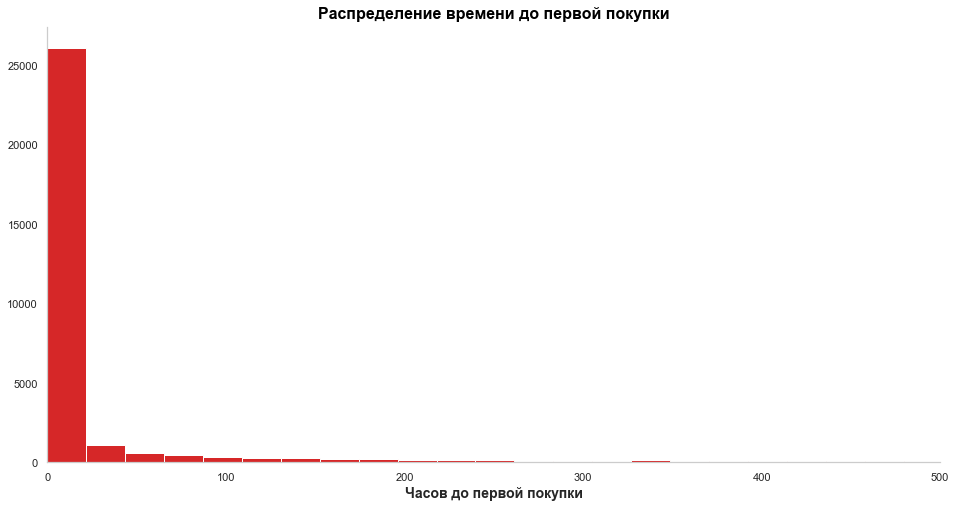

In [73]:
first_visits_orders['first_order_period_hours'].hist(
    bins=400,
    color='tab:red'
)
plt.xlim(0,500)

plt.title('Распределение времени до первой покупки', **title_font)
plt.xlabel('Часов до первой покупки', **axis_font)

plt.grid(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)


plt.show()

Выборка сильно смещена.  

In [74]:
first_visits_orders['first_order_period_hours'].describe()

count   36,522.0
mean       405.7
std      1,129.8
min          0.0
25%          0.1
50%          0.3
75%         48.3
max      8,719.1
Name: first_order_period_hours, dtype: float64

Из-за смещения выборки необходимо рассматривать медиану периода от визита до покупки — 20 мин.

#### Покупки за период

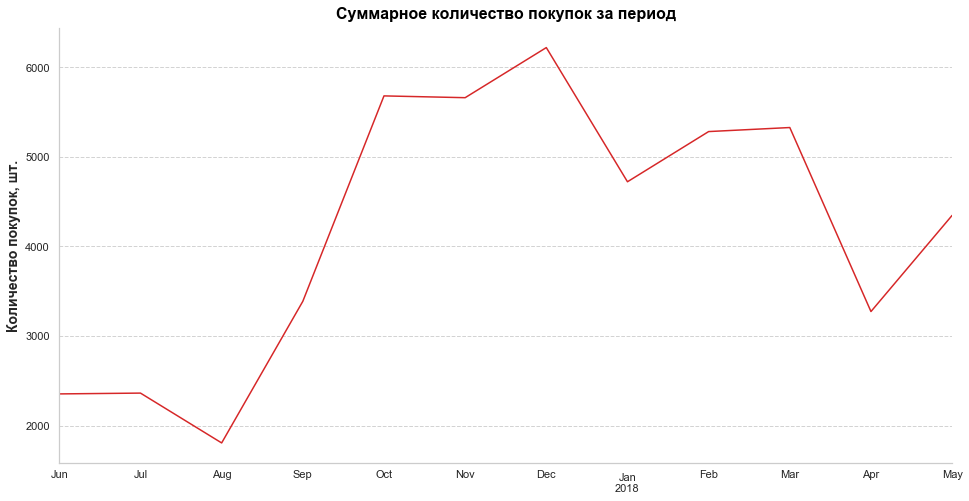

In [75]:
# формирование датафрейма покупок по месяцам
orders_by_month = cohorts.pivot_table(
    index='order_month',
    values='orders',
    aggfunc='sum'
)

# график покупок по месяцам
orders_by_month.plot(
    color='tab:red',
    legend=False
)

# подписи данных
plt.title('Суммарное количество покупок за период', **title_font)
plt.xlabel('', **axis_font)
plt.ylabel('Количество покупок, шт.', **axis_font)


# границы графика и сетка
plt.grid(False)
plt.grid(
    color='lightgrey',
    which='major',
    axis='y',
    linestyle='--'
)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.show()

Количество покупок растет в холодные месяцы годы, так как жители возвращаются из отпусков и проводят больше времени в городе.

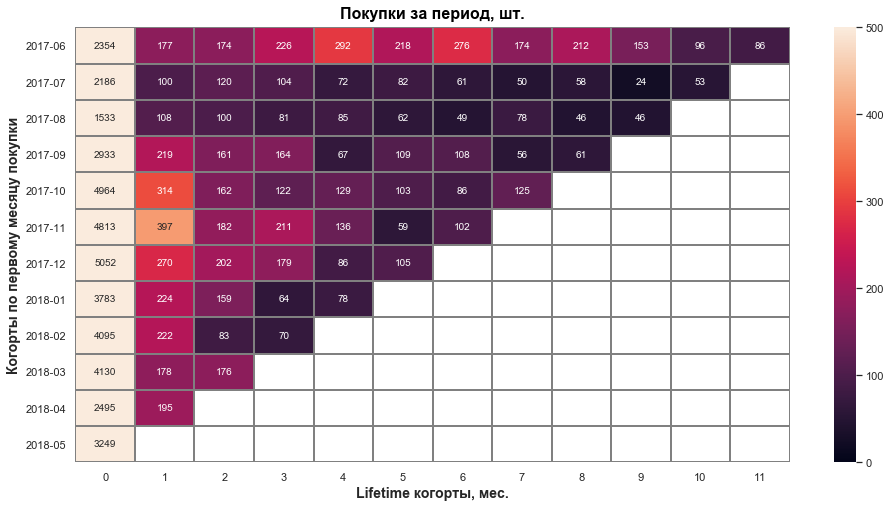

In [76]:
# формирование датафрейма покупок по когортам
orders_by_cohorts = cohorts.pivot_table(
    index='first_order_month',
    columns='cohort_lifetime',
    values='orders',
    aggfunc='mean'
)

# график покупок по когортам
plt.figure()

sns.heatmap(
    orders_by_cohorts,
    annot=True, 
    fmt='.0f', 
    linewidths=1,
    linecolor='gray',
   # xticklabels=buys_by_cohorts.columns.to_list().strftime('%Y-%m'),
    yticklabels=orders_by_cohorts.index.strftime('%Y-%m'),
    vmin=0, 
    vmax=500, 
)

plt.title('Покупки за период, шт.', **title_font)
plt.xlabel('Lifetime когорты, мес.', **axis_font)
plt.ylabel('Когорты по первому месяцу покупки', **axis_font)

plt.show()

- Пользователи наиболее активно покупают в первый месяц, но редко возвращаются за повторными покупками, что согласуется с sticky mau.
- Пик месячных покупок пришелся на октябрь-декабрь 2017 года — около 5 тыс.
- Повторные покупки в когорте в последующие месяцы колеблются между 50-300.

#### Средний чек покупки

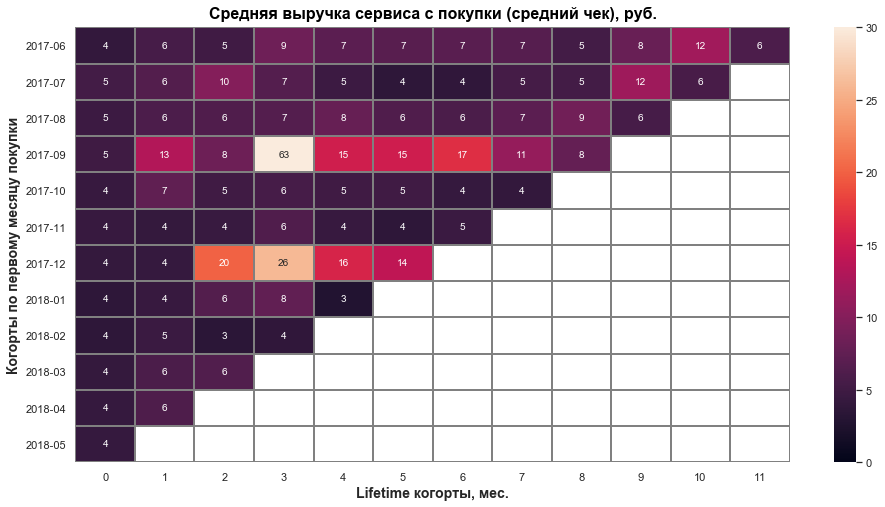

In [77]:
# формирование датафрейма среднего чека по когортам
revenue_per_order = cohorts.pivot_table(
    index='first_order_month',
    columns='cohort_lifetime',
    values='revenue_per_order',
    aggfunc='mean'
)

# график среднего чека по когортам
plt.figure()

sns.heatmap(
    revenue_per_order,
    annot=True, 
    fmt='.0f', 
    linewidths=1,
    linecolor='gray',
   # xticklabels=buys_by_cohorts.columns.to_list().strftime('%Y-%m'),
    yticklabels=revenue_per_order.index.strftime('%Y-%m'),
    vmin=0, 
    vmax=30, 
)

plt.title('Средняя выручка сервиса с покупки (средний чек), руб.', **title_font)
plt.xlabel('Lifetime когорты, мес.', **axis_font)
plt.ylabel('Когорты по первому месяцу покупки', **axis_font)

plt.show()

In [78]:
cohorts['revenue_per_order'].describe()

count   78.0
mean     7.7
std      7.5
min      2.7
25%      4.4
50%      5.8
75%      7.5
max     62.6
Name: revenue_per_order, dtype: float64

#### Среднияя выручка с покупателя ARPPU

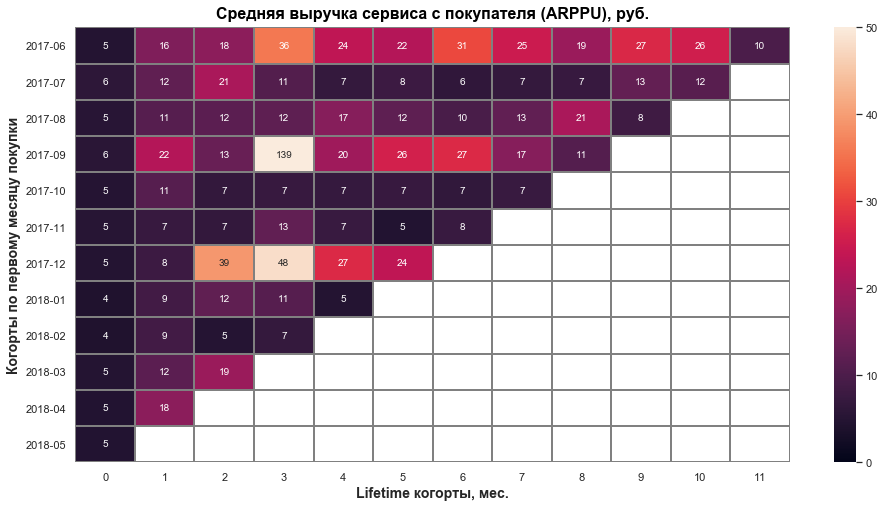

In [79]:
# формирование датафрейма средней выручки с покупателя
arppu = cohorts.pivot_table(
    index='first_order_month',
    columns='cohort_lifetime',
    values='revenue_per_user',
    aggfunc='mean'
)

# график средней выручки по когортам
plt.figure()

sns.heatmap(
    arppu,
    annot=True, 
    fmt='.0f', 
    linewidths=1,
    linecolor='gray',
   # xticklabels=buys_by_cohorts.columns.to_list().strftime('%Y-%m'),
    yticklabels=arppu.index.strftime('%Y-%m'),
    vmin=0, 
    vmax=50, 
)

plt.title('Средняя выручка сервиса с покупателя (ARPPU), руб.', **title_font)
plt.xlabel('Lifetime когорты, мес.', **axis_font)
plt.ylabel('Когорты по первому месяцу покупки', **axis_font)

plt.show()

Средняя выручка с покупателя в 0 месяц жизни когорты примерно одинаковая 5-6 руб.   
В следующие месяцы выручка с покупателя растет. Возвращающиеся покупатели тратят больше.
В некоторые когорты попали особые покупатели, которые заказывают больше, чем другие. Вероятно, это массовый заказ, например:
- для школ (2017-06, 2017-09 ): выручка постоянно больше, чем у других когорт.
- для компаний (2017-12): разовый крупный заказ.

Стоит проработать привлечение пользователей, которые покупают для организаций.

#### LTV покупателя

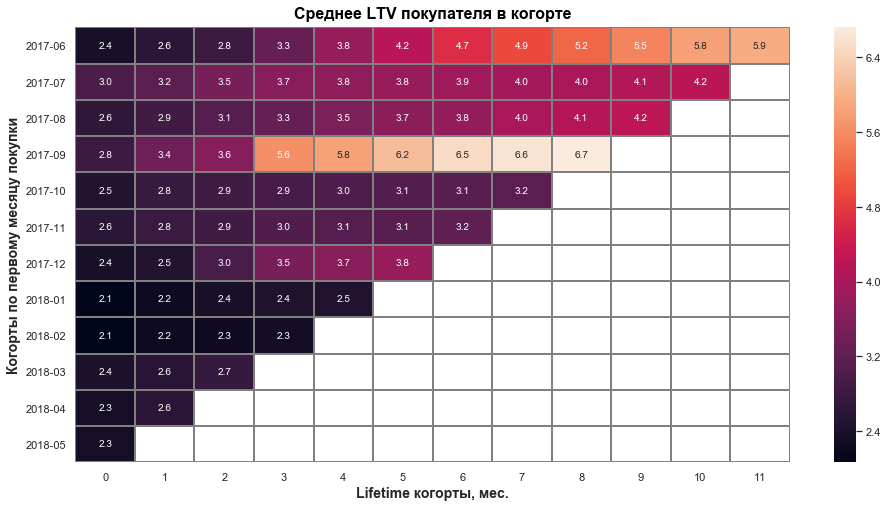

In [80]:
# формирование датафрейма по когортам
ltv = cohorts.pivot_table(
        index='first_order_month', 
        columns='cohort_lifetime', 
        values='ltv', 
        aggfunc='mean').cumsum(axis=1)

# график по когортам
plt.figure()

sns.heatmap(
    ltv,
    annot=True, 
    fmt='.1f', 
    linewidths=1,
    linecolor='gray',
    yticklabels=ltv.index.strftime('%Y-%m'),
  #  vmin=0, 
  #  vmax=4000, 
)

plt.title('Среднее LTV покупателя в когорте', **title_font)
plt.xlabel('Lifetime когорты, мес.', **axis_font)
plt.ylabel('Когорты по первому месяцу покупки', **axis_font)

plt.show()

In [81]:
# выбор периода жизни когорты для сравнения среднего LTV
cohort_lifetime_slice = 6 

In [82]:
# расчет ltv по когортам
ltv_by_uid = ltv.iloc[:, 0:cohort_lifetime_slice].dropna().max(axis=1).sort_values(ascending=False)

In [83]:
ltv_by_uid

first_order_month
2017-09-01   6.2
2017-06-01   4.2
2017-07-01   3.8
2017-12-01   3.8
2017-08-01   3.7
2017-11-01   3.1
2017-10-01   3.1
dtype: float64

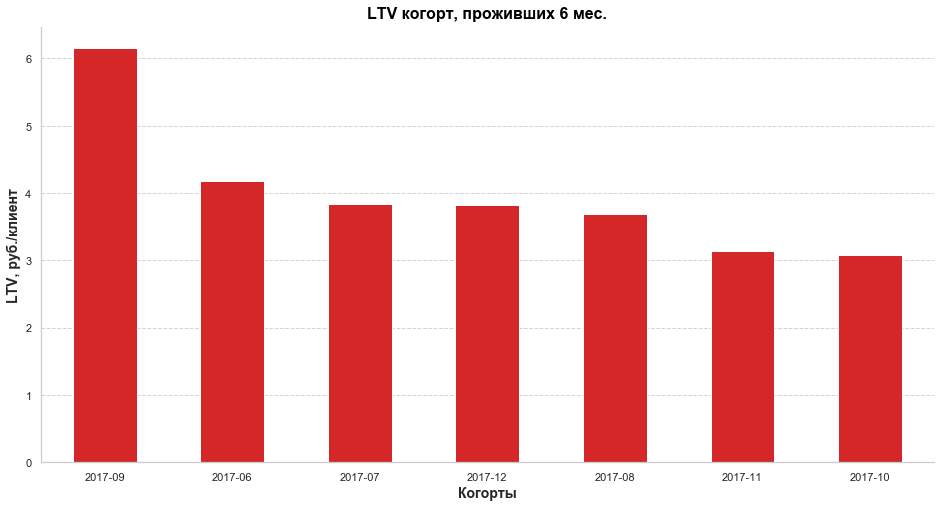

In [84]:
# график ltv по когортам
ltv_by_uid.plot.bar(
    color='tab:red'
)

plt.title('LTV когорт, проживших {} мес.'.format(cohort_lifetime_slice), **title_font)
plt.xlabel('Когорты', **axis_font)
plt.ylabel('LTV, руб./клиент', **axis_font)

plt.gca().set_xticklabels(
    ltv_by_uid.index.strftime('%Y-%m').to_list(),
    rotation=0
)

# границы графика и сетка
plt.grid(False)
plt.grid(
    color='lightgrey',
    which='major',
    axis='y',
    linestyle='--'
)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.show()

#### Gross profit когорт

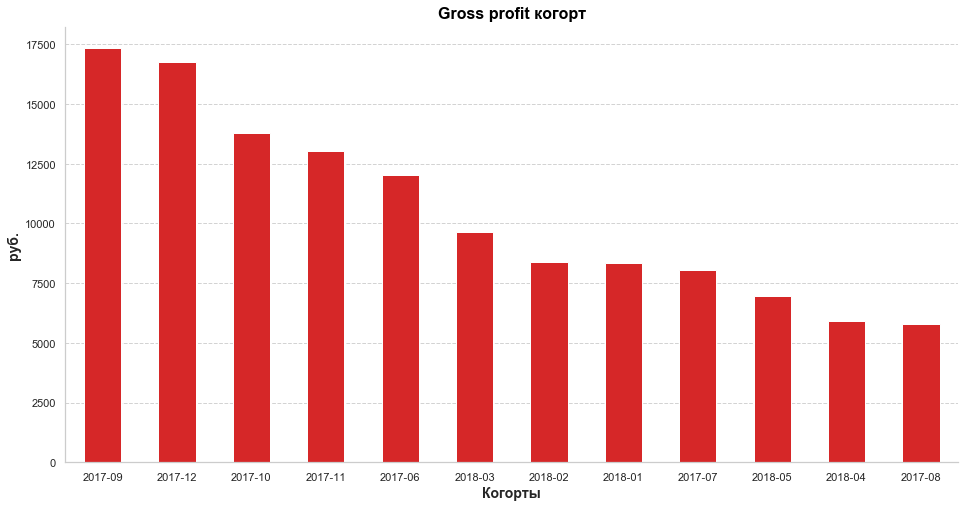

In [85]:
# расчет gross profit по когортам
gross_profit_by_cohort = cohorts.groupby('first_order_month')['gp'].sum().sort_values(ascending=False)

# график ltv по когортам
gross_profit_by_cohort.plot.bar(
    color='tab:red'
)

plt.title('Gross profit когорт', **title_font)
plt.xlabel('Когорты', **axis_font)
plt.ylabel('руб.', **axis_font)

plt.gca().set_xticklabels(
    gross_profit_by_cohort.index.strftime('%Y-%m').to_list(),
    rotation=0
)

# границы графика и сетка
plt.grid(False)
plt.grid(
    color='lightgrey',
    which='major',
    axis='y',
    linestyle='--'
)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.show()

#### Retention rate

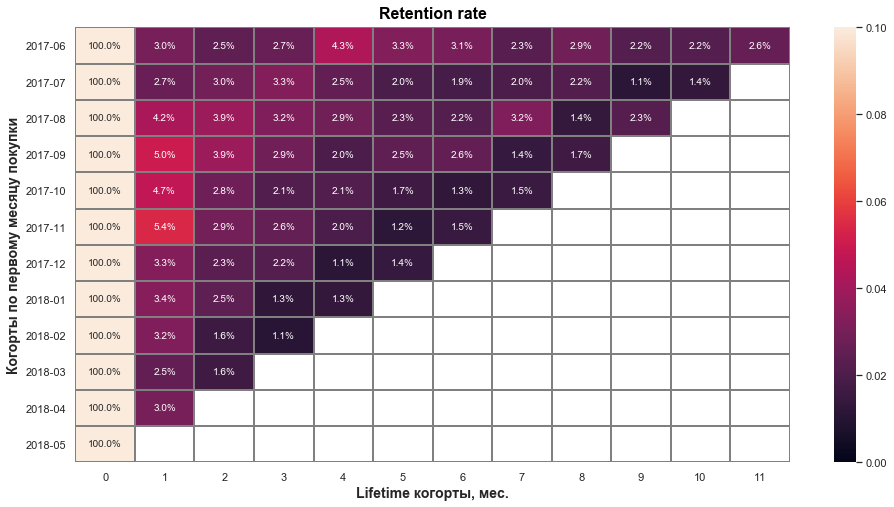

In [86]:
# формирование датафрейма по когортам
retention = cohorts.pivot_table(
        index='first_order_month', 
        columns='cohort_lifetime', 
        values='retention', 
        aggfunc='mean')#.cumsum(axis=1)

# график по когортам
plt.figure()

sns.heatmap(
    retention,
    annot=True, 
    fmt='.1%', 
    linewidths=1,
    linecolor='gray',
    yticklabels=ltv.index.strftime('%Y-%m'),
    vmin=0, 
    vmax=.1, 
)

plt.title('Retention rate', **title_font)
plt.xlabel('Lifetime когорты, мес.', **axis_font)
plt.ylabel('Когорты по первому месяцу покупки', **axis_font)

plt.show()

- LTV клиента c каждой когорты составляет от 2 до 4 руб. Отдельные клиенты (корпоративные?) приносят 6-7 руб.   
- Gross profit c каждой когорты составляет от 5 до 17,5 тыс. руб. После первого месяца когорта не приносит много прибыли, если в нее не попадают активные корпоративные покупатели, как в 2017-06, 2017-09.
- Retention rate низкий: 2,5-5% на следующий месяц после первой покупки. Больший коэффициент характерен для когорт, которые попадают на предновогодние месяцы . В последующие месяцы доля возвращающихся падает до 1,5% с отдельными несистемными выбросами, попадающими на праздники. 
- Необходимо изучить профиль пользователей когорты 2017-06, 2017-09 для фокусировки маркетинговой стратегии на них.

#### Промежуточный вывод по продажам

__Результаты:__
- По медиане пользователи начинают покупать через 20 мин.  после первой сессии.
- Конверсия в покупку на Яндекс.Афише: 16%
- Пользователи наиболее активно покупают в первый месяц жизни когорты: 3-5 тыс. покупок.
- Пользователи редко возвращаются за повторными покупками: в последующие месяцы на когорту приходится в среднем до 100 покупок.
- Общее количество покупок растет в холодные месяцы годы, так как жители возвращаются из отпусков и проводят больше времени в городе.
- Медианная выручка сервиса с покупки: 5,8 руб. Среднюю выручку считать некорректно, так как попадаются выбросы (до 60 руб. с покупки) из-за актитвных пользователей в отдельных когортах.
- LTV клиента c каждой когорты составляет от 2 до 4 руб. Отдельные клиенты (корпоративные?) приносят 6-7 руб.
- Retention rate низкий: 2,5-5% на следующий месяц после первой покупки и с падением до 1,5% в следующие месяцы.
- Gross profit c каждой когорты составляет от 5 до 17,5 тыс. руб. После первого месяца когорта не приносит много прибыли, если в нее не попадают активные корпоративные покупатели, как в 2017-06, 2017-09.   

__Рекомендации:__
- Выявить профили активных пользователей когорт 2017-06, 2017-09 и сфокусировать маркетинговую стратегию на них (провести А/В тестирование).
- Учитывать сезонность холодного периода и начинать рекламные кампании к этому времени. 

### Маркетинг
<a id = "marketing"></a>

##### Суммарные затраты по рекламным источникам

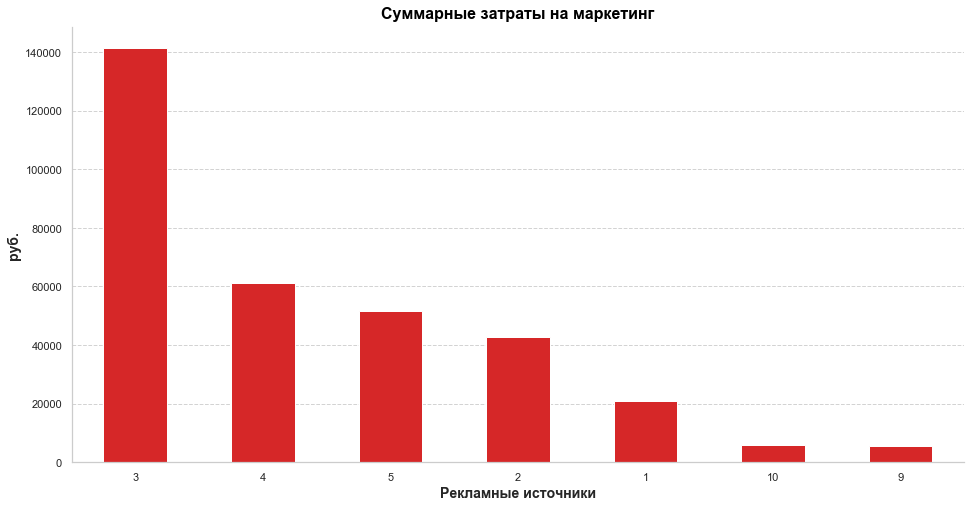

In [87]:
# датафрейм суммарных затрат по источникам

costs_by_source = costs.groupby('source_id')['costs'].sum().sort_values(ascending=False)#.reset_index()

costs_by_source.plot.bar(
    color='tab:red'
)

plt.title('Суммарные затраты на маркетинг', **title_font)
plt.xlabel('Рекламные источники', **axis_font)
plt.ylabel('руб.', **axis_font)
plt.gca().set_xticklabels(
    costs_by_source.index,
    rotation=0
)

# границы графика и сетка
plt.grid(False)
plt.grid(
    color='lightgrey',
    which='major',
    axis='y',
    linestyle='--'
)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.show()

Наибольшие затраты на маркетинг 43% приходятся на рекламный источник 3 — 141 тыс руб.   
Примерно еще 40% затрат распределены на рекламные источники 4, 5 и 2 по 61, 51 и 42 тыс. руб. соответствено.

##### Затраты по рекламным источникам по времени

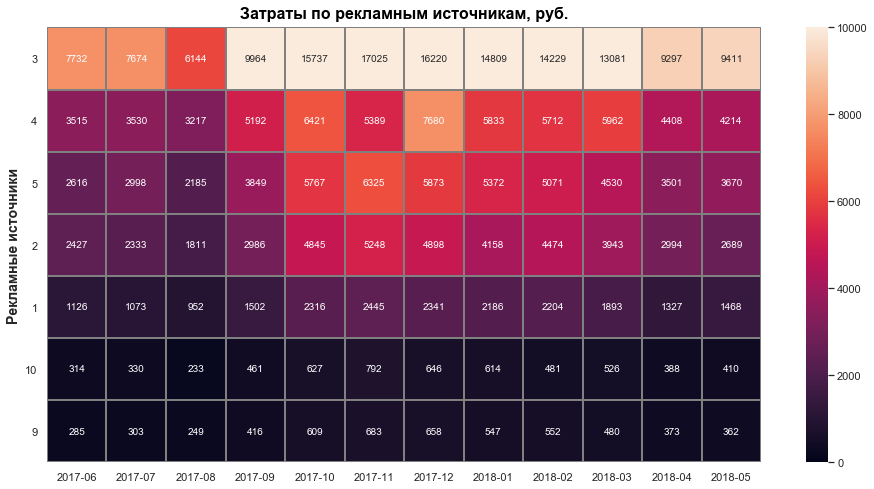

In [88]:
# датафрейм затрат по источникам по времени
costs_per_source_pivot = costs.pivot_table(
    index='source_id',
    columns='cost_month',
    values='costs',
    aggfunc='sum'
)
# упорядочивание затрат по убыванию
costs_per_source_pivot = costs_per_source_pivot.reindex(index=costs_by_source.index)



# график затрат по источникам по времени

g = sns.heatmap(
    costs_per_source_pivot, 
    annot=True, 
    fmt='.0f', 
    linewidths=1, 
    linecolor='gray',
    xticklabels=costs_per_source_pivot.columns.strftime('%Y-%m'),
    vmin=0, 
    vmax=10000, 
)

g.set_yticklabels(
    g.get_yticklabels(),
    rotation=0,
)

plt.title('Затраты по рекламным источникам, руб.', **title_font)
plt.xlabel('', **axis_font)
plt.ylabel('Рекламные источники', **axis_font)

plt.show()

По всем рекламным источникам затраты начинают расти за 2-3 месяца до новогодних праздников.
Пик затрат приходится на ноябрь и декабрь 2017 года.

#### CAC. Привлечение покупателей по источникам

In [89]:
clients_by_source = orders_new.groupby('uid').agg(
    {'order_date': 'min',
     'source_id': 'first'}).reset_index().groupby('source_id')['uid'].count().reset_index()

In [90]:
# свод датафрейма первых посещений и затрат по источниками
cac = pd.merge(clients_by_source, costs_by_source, how='left', on='source_id').fillna(0)
cac.rename(columns={'uid': 'clients'}, inplace=True)


# расчет стоимости привлечения
cac['cac'] = cac['costs'] / cac['clients']

cac = cac.sort_values('cac', ascending=False)

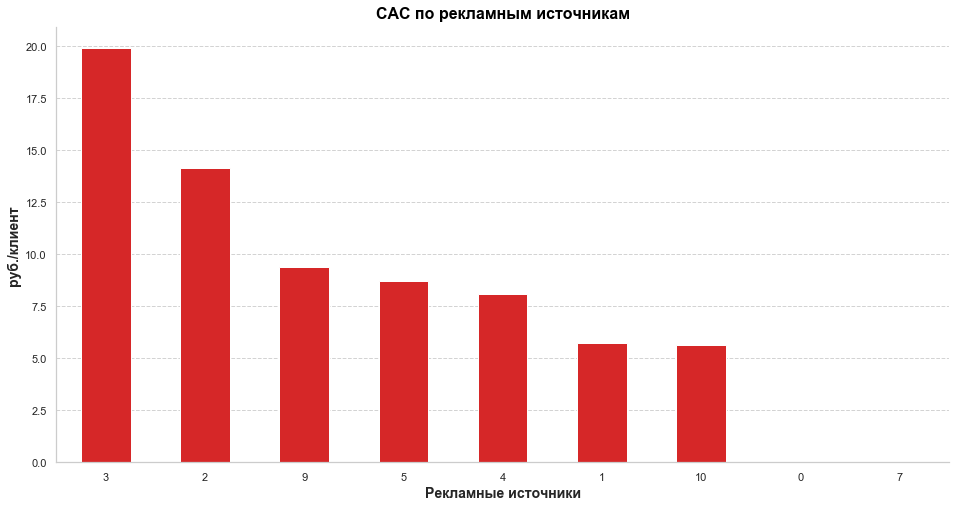

In [91]:
cac['cac'].plot.bar(
    color='tab:red'
)

plt.title('CAC по рекламным источникам', **title_font)
plt.xlabel('Рекламные источники', **axis_font)
plt.ylabel('руб./клиент', **axis_font)
plt.gca().set_xticklabels(
    cac['source_id'],
    rotation=0
)

# границы графика и сетка
plt.grid(False)
plt.grid(
    color='lightgrey',
    which='major',
    axis='y',
    linestyle='--'
)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.show()

Самое дорогое привлечение покупателя приходится на рекламный источник 3.   
Рекламные источники 4 и 5 дают соизмеримый трафик, но стоят в 2 раза дешевле.  
__Необходимо оптимизировать рекламную стратегию.__

### ROI. Окупаемость расходов

In [92]:
# свод roi
roi = cohorts.pivot_table(
        index='first_order_month',
        columns='cohort_lifetime', 
        values='roi', 
        aggfunc='mean')

In [93]:
# накопительный ROI
roi.cumsum(axis=1).round(2).fillna('')

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,0.3,0.3,0.3,0.4,0.4,0.5,0.5,0.6,0.6,0.6,0.7,0.7
2017-07-01,0.3,0.3,0.4,0.4,0.4,0.4,0.4,0.4,0.4,0.4,0.4,
2017-08-01,0.2,0.3,0.3,0.3,0.3,0.3,0.3,0.4,0.4,0.4,,
2017-09-01,0.3,0.4,0.4,0.6,0.6,0.7,0.7,0.7,0.7,,,
2017-10-01,0.3,0.3,0.3,0.3,0.4,0.4,0.4,0.4,,,,
2017-11-01,0.3,0.3,0.3,0.3,0.3,0.3,0.3,,,,,
2017-12-01,0.3,0.3,0.3,0.4,0.4,0.4,,,,,,
2018-01-01,0.2,0.2,0.2,0.2,0.2,,,,,,,
2018-02-01,0.2,0.2,0.2,0.3,,,,,,,,


In [94]:
# средний накопительный ROMI
roi.cumsum(axis=1).mean(axis=0)

cohort_lifetime
0    0.3
1    0.3
2    0.3
3    0.4
4    0.4
5    0.4
6    0.4
7    0.5
8    0.5
9    0.5
10   0.5
11   0.7
dtype: float64

Затраты на когорты не окупаются.

## Общий вывод
<a id = "resume"></a>

- За период 12 месяцев выручка стабильно меньше затрат:
    - Выручка: 252 054 руб.
    - Затраты на маркетинг: -329 132 руб.
    - Общий убыток: -77 078 руб.
- Первая когорта 2017-06 еще не окупилась за год.
- Показатель sticky mau ниже 5%. Большинство клиентыов не возвращаются после первой покупки.
- Маркетинговую стратегию необходимо сфокусировать на:
    - клиентов со стационарных устройств — 73% трафика
    - рекламные источники 4 и 5. У них CAC 7-8 руб., а трафик на уровне 3 источника с CAC 19 руб.
- Конверсия в покупку на Яндекс.Афише: 16%. По <a href="https://vc.ru/marketing/83184-konversiya-internet-magazina-v-10-15-pravda-ili-vymysel">оценкам</a> отраслевых экспертов возможен потенциал повышения этого показателя. Необходимо проанализировать узкие места воронки продаж или дополнить сервис новыми функциями.
- Пользователи начинают покупать через 0,3 часа после первой сессии. Стоит сделать провести A/B тест и направлять напоминание для мотивации остальных пользователей сделать или завершить покупку.
- Необходима проверка причин 10% нулевых сессий от общего количества.
- Выявить профили активных пользователей когорт 2017-06, 2017-09 и сфокусировать маркетинговую стратегию на них (провести А/В тестирование).
- Учитывать сезонность холодного периода и начинать рекламные кампании для стационарных устройств за 2-3 месяца до Нового Года к этому времени. Сезонность для мобильных устройств выражена меньше.